In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, SequentialSampler, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import dgl
from dgl import DGLGraph
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import random
from math import ceil, sqrt
from collections import namedtuple, defaultdict
from tqdm import tqdm_notebook as tqdm
from jupyterthemes import jtplot
from tqdm import tqdm_notebook as tqdm
from scipy import stats
from sklearn import preprocessing, metrics
import os
import glob
import ipdb
import copy
from utils import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
jtplot.style(ticks=True, figsize=(10, 10),theme='oceans16')

In [3]:
ScriptArgs = namedtuple('args', 'batch_size lr epochs seed log_interval max_seq_length batch_n interval_save_tensor model tweets_batch_size max_tweets')
args = ScriptArgs(
    batch_size=128, lr=3e-4, epochs=10, seed=1, 
    log_interval=100, max_seq_length=64, batch_n=1024,
    interval_save_tensor=100, model='distilbert-base-uncased',
    tweets_batch_size = 64, max_tweets=32
)

In [4]:
tweet_categs = Categories(['own_tweet', 'retweeted_by', 'replied_by', 'quoted_by', 'retweeted', 'replied', 'quoted'])
label_categs = Categories(['normal', 'hateful'])

In [5]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(args.seed)
torch.manual_seed(args.seed)
np.random.seed(args.seed)

In [6]:
def tstep_default(): return -1

In [7]:
tpath = './experiment_w_pretraining/user_dict_full.pkl'
user_dict_ds = torch.load(tpath)

In [8]:
user_mapping = Mapping([v.uID for k, v in user_dict_ds.items()])
num_users = len(user_mapping)

In [9]:
# for k,v in tqdm(user_dict_ds.items()):
#     v.uInd = user_mapping.ID2ind(v.uID)
#     v.df_updates['linked_uInd'] = v.df_updates.linked_uID.apply(lambda x: user_mapping.ID2ind(x))

In [10]:
timestamps = sorted(list(set.union(*[set(v.timesteps.keys()) for k,v in user_dict_ds.items() ] )))

In [11]:
import collections
model_args = collections.namedtuple('args', 'in_feats n_hidden_gcn n_hidden_lstm n_classes n_layers_pre_rnn n_layers_post_rnn dropout lr weight_decay')
args = model_args(in_feats=522, n_hidden_gcn=64, n_hidden_lstm = 64, n_classes=1, n_layers_pre_rnn=1, n_layers_post_rnn=1, dropout=.1, lr=3e-4, weight_decay=1e-6)

In [12]:
tweet_dim = user_dict_ds[user_mapping.ind2ID(0)].tweetvecs[0].size(0)
stdev = sqrt(args.n_hidden_lstm)
lstm_h_init = nn.Parameter(torch.rand(args.n_hidden_lstm, device=device)*2*stdev-stdev)
lstm_c_init = nn.Parameter(torch.rand(args.n_hidden_lstm, device=device)*2*stdev-stdev)
gru_h_init = nn.Parameter(torch.rand(args.n_hidden_lstm, device=device)*2*stdev-stdev)
# empty_tweet = nn.Parameter(torch.rand(tweet_dim, device=device)*2*sqrt(tweet_dim)-sqrt(tweet_dim))

In [13]:
l_x, l_y, mask_y = [], [], []
for i in tqdm(range(num_users)):
    u = user_dict_ds[user_mapping.ind2ID(i)]
    l_x.append(u.features)
    mask_y.append(True if u.label is not None else False)
    l_y.append(u.label if u.label is not None else -1)
    for k in u.tweetvecs:
        k.requires_grad = False
        k = k.to('cpu')
#     if isinstance(u.tweetvecs, list):
#         if u.tweetvecs[-1].requires_grad:
#             u.tweetvecs[-1] = empty_tweet
#         else:
#             u.tweetvecs.append(empty_tweet)
#     else:
#         u.tweetvecs = [k.to(device) for k in u.tweetvecs] + [empty_tweet]

In [18]:
%%time
kkl = []
for i in tqdm(range(num_users)):
    u = user_dict_ds[user_mapping.ind2ID(i)]
    u_df = process_df_updates(u)
    if u_df.shape[0] > 0: 
        kkl.append(u_df)


CPU times: user 35min 40s, sys: 8.68 s, total: 35min 49s
Wall time: 36min 43s


In [19]:
df_upd_add_edge = pd.concat(kkl).sort_index()

temp_df_newedge = df_upd_add_edge.reset_index().set_index('uInd').sort_index()
temp_df_newedge = temp_df_newedge[['date','linked_uInd']]

In [16]:
edge_mapping = Mapping([(uind, linkeduind) for uind, linkeduind in df_upd_add_edge[['uInd', 'linked_uInd']].itertuples(index=False)])

In [32]:
%%time
l_upd_existing_edge = []
for i in tqdm(range(num_users)):
    u = user_dict_ds[user_mapping.ind2ID(i)]
    u_df = df_upd_existing_edge(u, temp_df_newedge)
    if u_df is not None and u_df.shape[0] > 0: 
        l_upd_existing_edge.append(u_df)


CPU times: user 36min 55s, sys: 7.19 s, total: 37min 2s
Wall time: 37min 54s


In [41]:
df_upd_existing_edge = pd.concat(l_upd_existing_edge).sort_index()

In [46]:
df_upd_existing_edge['edge_id'] = df_upd_existing_edge.apply(
    lambda row: edge_mapping.ID2ind((row.uInd, row.linked_uInd)), axis=1)

In [14]:
tpath = './experiment_w_pretraining/edges_over_time.pkl'
if not os.path.isfile(tpath):
    torch.save({
        'df_upd_add_edge': df_upd_add_edge, 
        'df_upd_existing_edge': df_upd_existing_edge},
        tpath
    )
else:
    temp = torch.load(tpath)
    df_upd_add_edge = temp['df_upd_add_edge']
    df_upd_existing_edge = temp['df_upd_existing_edge']
    del temp
    edge_mapping = Mapping([(uind, linkeduind) for uind, linkeduind in df_upd_add_edge[['uInd', 'linked_uInd']].itertuples(index=False)])


In [15]:
print(df_upd_add_edge.shape)
print(df_upd_existing_edge.shape)

(3149250, 8)
(849908, 9)


forgot to remove self edges:/

In [49]:
df_upd_add_edge = df_upd_add_edge[df_upd_add_edge.uInd != df_upd_add_edge.linked_uInd]
df_upd_existing_edge = df_upd_existing_edge[df_upd_existing_edge.uInd != df_upd_existing_edge.linked_uInd]
edge_mapping = Mapping([(uind, linkeduind) for uind, linkeduind in df_upd_add_edge[['uInd', 'linked_uInd']].itertuples(index=False)])

In [50]:
df_upd_existing_edge['edge_id'] = df_upd_existing_edge.apply(
    lambda row: edge_mapping.ID2ind((row.uInd, row.linked_uInd)), axis=1)

In [51]:
print(df_upd_add_edge.shape)
print(df_upd_existing_edge.shape)

(3149250, 8)
(849908, 9)


###  Graph

In [66]:
degree_cols = [str(k) for k in range(1,7)]

In [67]:
G = dgl.DGLGraph()
G.add_nodes(num_users)

G.ndata['x'] = torch.Tensor(np.stack(l_x)).to(device)
G.ndata['y'] = torch.LongTensor(l_y).to(device)
G.ndata['y_mask'] = torch.BoolTensor(mask_y).to(device)

t = timestamps[0]

df_t = df_upd_add_edge.loc[t]
G.add_edges(
    df_t.uInd.to_list(), 
    df_t.linked_uInd.to_list(), 
    data={'degrees':torch.Tensor(df_t[degree_cols].values).to(device)}
)
calc_norms(G, device)

In [69]:
# G.ndata['degrees'] = torch.zeros(num_users, 6, device=device) 

In [75]:
t = timestamps[1]

In [76]:
df_t = df_upd_add_edge.loc[t]
G.add_edges(
    df_t.uInd.to_list(), 
    df_t.linked_uInd.to_list(), 
    data={'degrees':torch.Tensor(df_t[degree_cols].values).to(device)}
)
calc_norms(G)

df_upt_t = df_upd_existing_edge.loc[t]
loc_idx = torch.LongTensor(df_upt_t.loc[t].edge_id.values)
G.edata['degrees'][loc_idx] = G.edata['degrees'][loc_idx] + torch.Tensor(df_upt_t[degree_cols].values).to(device)

In [77]:
loc_idx.shape

torch.Size([1784])

In [17]:
class GCNLayer(nn.Module):
    def __init__(self,
                 g,
                 in_feats,
                 out_feats,
                 activation,
                 dropout,
                ):
        super().__init__()
        self.g = g
        self.in_feats = in_feats
        self.out_feats = out_feats
        self.activation = activation
        self.dropout = nn.Dropout(p=dropout) if dropout else 0.
        self.linear_self = nn.Linear(in_feats, out_feats)   
        self.linear_node = nn.Linear(in_feats, out_feats*6)        
        self.linear_edge = nn.Linear(6,out_feats, bias=False) # separately for src and dst
        self.node_apply_activation = activation
        self.bias = nn.Parameter(torch.Tensor(out_feats))
#         self.gcn_apply_gru_cell = nn.GRUCell(out_feats, out_feats)

    def gcn_msg(self, edge):
        msg = edge.data['h_degrees']
        for i in range(6):
            msg = msg + edge.src['h_node_msg'][
                :,i*self.out_feats:(i+1)*self.out_feats] * (edge.data['h_degrees'][:,i]>0).float()[:,None]
        msg = msg * edge.src['norm']
        return {'m': msg}
    
    def gcn_reduce(self, node):
        accum = torch.sum(node.mailbox['m'], 1) * node.data['norm']
        return {'h': accum}

    def node_apply(self, nodes):
        h = nodes.data['h'] + nodes.data['h_node_self']
        if self.bias is not None:
            h = h + self.bias[None,:]
        if self.activation:
            h = self.activation(h)
        return {'h': h}
    
    def forward(self, h):
        if self.dropout: h = self.dropout(h)
        self.g.ndata['h_node_msg'] = self.linear_node(h)
        self.g.ndata['h_node_self'] = self.linear_self(h)
        self.g.edata['h_degrees'] = self.linear_edge(self.g.edata['degrees'])
                                                     
        self.g.update_all(self.gcn_msg, self.gcn_reduce, self.node_apply)
        h = self.g.ndata.pop('h')
        return h


class GCN(nn.Module):
    def __init__(self,
                 g,
                 in_feats,
                 n_hidden_gcn,
                 n_hidden_gru,
                 n_hidden_lstm,
                 n_classes,
                 n_layers_pre_rnn,
                 n_layers_post_rnn,
                 activation,
                 dropout):
        super().__init__()
        self.in_feats = in_feats
        self.n_hidden_gru = n_hidden_gru
        self.n_hidden_lstm = n_hidden_lstm
        self.n_hidden_gcn = n_hidden_gcn
        self.n_classes = n_classes

        self.layers_pre_rnn = nn.ModuleList()
        self.layers_post_rnn = nn.ModuleList()

        # input layer
        self.layers_pre_rnn.append(GCNLayer(g, in_feats, n_hidden_gcn, activation, dropout))
        # hidden layers pre lstm
        for i in range(n_layers_pre_rnn - 1):
            self.layers_pre_rnn.append(GCNLayer(g, n_hidden_gcn, n_hidden_gcn, activation, dropout))
        # rnn cells
        self.gru_cell_emb = nn.GRUCell(n_hidden_gcn, n_hidden_gru)
        self.lstm_cell = nn.LSTMCell(n_hidden_gcn, n_hidden_lstm,)
        # initial layer post lstm
        self.layers_post_rnn.append(GCNLayer(g, n_hidden_lstm, n_hidden_gcn, activation, dropout))
        # hidden layers post lstm
        for i in range(n_layers_post_rnn - 1):
            self.layers_post_rnn.append(GCNLayer(g, n_hidden_gcn, n_hidden_gcn, activation, dropout))
        # output layer
#         self.linear_emb = nn.Linear(n_hidden_gcn, in_feats)
#         self.layers_post_rnn.append(GCNLayer(g, n_hidden_gcn, n_classes, None, dropout))

    def forward(self, features, hidden_gru, hidden_states): #, existing_nodes):
#         ipdb.set_trace()
        h = features #[existing_nodes]
        for layer in self.layers_pre_rnn:
            h = layer(h)
        h_lstm, c_lstm = self.lstm_cell(h, hidden_states)#[existing_nodes])
        h = self.layers_post_rnn[0](h_lstm)
        for layer in self.layers_post_rnn[1:]:
            h = layer(h)
#         h_e = self.linear_emb(h)
        hidden_gru = self.gru_cell_emb(h, hidden_gru) #[existing_nodes])
        return hidden_gru, (h_lstm, c_lstm)


In [18]:
import collections
model_args = collections.namedtuple('args', 'in_feats n_hidden_gcn n_hidden_lstm n_hidden_gru n_classes n_layers_pre_rnn n_layers_post_rnn dropout lr weight_decay')
args = model_args(in_feats=522, n_hidden_gcn=64, n_hidden_lstm = 32, n_hidden_gru=16, n_classes=1, n_layers_pre_rnn=1, n_layers_post_rnn=1, dropout=.1, lr=3e-4, weight_decay=1e-6)

In [19]:
lstm_h_init = nn.Parameter(torch.rand(args.n_hidden_lstm, device=device)*2*stdev-stdev)
lstm_c_init = nn.Parameter(torch.rand(args.n_hidden_lstm, device=device)*2*stdev-stdev)
gru_h_init = nn.Parameter(torch.rand(args.n_hidden_gru, device=device)*2*stdev-stdev)
# empty_tweet = nn.Parameter(torch.rand(tweet_dim, device=device)*2*sqrt(tweet_dim)-sqrt(tweet_dim))

In [20]:
G = dgl.DGLGraph()
G.add_nodes(num_users)

G.ndata['x'] = torch.Tensor(np.stack(l_x)).to(device)
G.ndata['y'] = torch.Tensor(l_y).to(device)
G.ndata['y_mask'] = torch.BoolTensor(mask_y).to(device)

In [30]:
model = GCN(
    G,
    args.in_feats,
    args.n_hidden_gcn,
    args.n_hidden_gru,
    args.n_hidden_lstm,
    args.n_classes,
    args.n_layers_pre_rnn,
    args.n_layers_post_rnn,
    nn.LeakyReLU(.01),
    args.dropout).to(device)
MLP = nn.Linear(args.n_hidden_gru, args.n_classes).to(device)

In [47]:
criterion = torch.nn.BCEWithLogitsLoss(reduction='none')
optimizer = torch.optim.Adam(list(model.parameters()) + [lstm_h_init, lstm_c_init, gru_h_init] + list(MLP.parameters()), lr=1e-2, weight_decay=args.weight_decay)
# optimizer = torch.optim.Adam(list(model.parameters()) + list(MLP.parameters()), lr=args.lr, weight_decay=args.weight_decay)

In [32]:
# lstm_h_init = torch.zeros(args.n_hidden_lstm, device=device)
# lstm_c_init = torch.zeros(args.n_hidden_lstm, device=device)
# gru_h_init = torch.zeros(args.n_hidden_lstm, device=device)

In [33]:
from sklearn import preprocessing, metrics

In [34]:
temp_mask = torch.distributions.Binomial(1,.8)
training_mask_temp = temp_mask.sample([num_users])
training_mask = (torch.Tensor(mask_y) * training_mask_temp).bool().to(device)
valid_mask = (torch.Tensor(mask_y) * (1-training_mask_temp)).bool().to(device)

In [48]:
num_epochs = 1
detach_at = 2
degree_cols = [str(k) for k in range(1,7)]

for epoch in range(num_epochs):
    G.clear()
    G.add_nodes(num_users)

    G.ndata['x'] = torch.Tensor(np.stack(l_x)).to(device)
    G.ndata['y'] = torch.Tensor(l_y).to(device)
#     G.ndata['y_mask'] = torch.BoolTensor(mask_y).to(device)

    t = timestamps[0]

    df_t = df_upd_add_edge.loc[t]
    G.add_edges(
        df_t.uInd.to_list(), 
        df_t.linked_uInd.to_list(), 
        data={'degrees':torch.Tensor(df_t[degree_cols].values).to(device)}
    )
    calc_norms(G, device)
    
    h_gru, (h_lstm, c_lstm) = model(
        G.ndata['x'],
        gru_h_init.expand(num_users,args.n_hidden_gru), 
        (lstm_h_init.expand(num_users,args.n_hidden_lstm), 
         lstm_c_init.expand(num_users,args.n_hidden_lstm)))
    
    loss = 0
    edge_num = 0
    for i,t in enumerate(timestamps[1:]):
        df_t = df_upd_add_edge.loc[t]
        G.add_edges(
            df_t.uInd.to_list(), 
            df_t.linked_uInd.to_list(), 
            data={'degrees':torch.Tensor(df_t[degree_cols].values).to(device)}
        )
        calc_norms(G)

        df_upt_t = df_upd_existing_edge.loc[t]
        loc_idx = torch.LongTensor(df_upt_t.loc[t].edge_id.values)
        G.edata['degrees'][loc_idx] = G.edata['degrees'][loc_idx] + torch.Tensor(df_upt_t[degree_cols].values).to(device)
        
        h_gru, (h_lstm, c_lstm) = model(G.ndata['x'], h_gru, (h_lstm, c_lstm))
        
        print(t)

        if ((i+1)%detach_at == 0) or (i+2 == len(timestamps)):
            # predict edge labels at time `t`
            y_logits = MLP(h_gru).flatten()
            loss = criterion(y_logits[training_mask], G.ndata['y'][training_mask])
            loss += loss * G.ndata['y'][training_mask] * 9
            loss = loss.sum()
            print(f'loss: {loss.item()}')
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            valid_loss = criterion(y_logits[valid_mask], G.ndata['y'][valid_mask])
            valid_loss += valid_loss * G.ndata['y'][valid_mask] * 9
            valid_loss = valid_loss.sum()
            print(f'validation loss: {valid_loss.item()}')
            fpr, tpr, thresholds = metrics.roc_curve(
                G.ndata['y'][valid_mask].cpu().numpy(),
                torch.sigmoid(y_logits[valid_mask]).detach().cpu().numpy())
            auc = metrics.auc(fpr, tpr)
            print(f'auc: {auc}')

            h_gru, h_lstm, c_lstm  = h_gru.detach(), h_lstm.detach(), c_lstm.detach()

2017-09-01T00:00:00.000000000
2017-09-02T00:00:00.000000000
loss: 17128.6171875
validation loss: 4342.0712890625
auc: 0.5
2017-09-03T00:00:00.000000000
2017-09-04T00:00:00.000000000
loss: 15178.212890625
validation loss: 3848.153076171875
auc: 0.5
2017-09-05T00:00:00.000000000
2017-09-06T00:00:00.000000000
loss: 13282.033203125
validation loss: 3368.222412109375
auc: 0.5
2017-09-07T00:00:00.000000000
2017-09-08T00:00:00.000000000
loss: 11579.91015625
validation loss: 2937.771240234375
auc: 0.5
2017-09-09T00:00:00.000000000
2017-09-10T00:00:00.000000000
loss: 10141.265625
validation loss: 2574.407470703125
auc: 0.5
2017-09-11T00:00:00.000000000
2017-09-12T00:00:00.000000000
loss: 8821.00390625
validation loss: 2241.5810546875
auc: 0.5
2017-09-13T00:00:00.000000000
2017-09-14T00:00:00.000000000
loss: 7663.36962890625
validation loss: 1950.6695556640625
auc: 0.5
2017-09-15T00:00:00.000000000
2017-09-16T00:00:00.000000000
loss: 6714.7421875
validation loss: 1713.5831298828125
auc: 0.5
2017

KeyboardInterrupt: 

In [42]:
G.ndata['y'][training_mask]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')

In [40]:
torch.sigmoid(y_logits[training_mask])

tensor([0.0155, 0.0155, 0.0155,  ..., 0.0155, 0.0155, 0.0155], device='cuda:0',
       grad_fn=<SigmoidBackward>)

In [268]:
def get_timing_signal(length, channels,
                      min_timescale=1.0, max_timescale=1.0e4):
    position = torch.arange(length).type(torch.float32)
    num_timescales = channels // 2
    log_timescale_increment = (math.log(float(max_timescale) / float(min_timescale)) / (float(num_timescales) - 1))
    inv_timescales = min_timescale * torch.exp(
            torch.arange(num_timescales).type(torch.float32) * -log_timescale_increment)
    scaled_time = position.unsqueeze(1) * inv_timescales.unsqueeze(0)
    signal = torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], dim = 1)
    m = nn.ZeroPad2d((0, (channels % 2), 0, 0))
    signal = m(signal)
    signal = signal.view(1, length, channels)
    return signal


In [270]:
time_signal = get_timing_signal(61, 128)[0].to(device)

In [218]:
df_upd_add_edge

,linked_uInd,1,2,3,4,5,6,uInd
date,,,,,,,,
2017-01-01,98310,7,0,4,6,0,0,20930
2017-01-01,44209,3,0,0,0,0,0,11965
2017-01-01,37819,1,0,0,0,0,0,11965
2017-01-01,26495,0,0,0,0,1,0,11965
2017-01-01,24182,0,0,0,0,0,1,11965
...,...,...,...,...,...,...,...,...
2017-11-01,35814,0,0,0,0,1,0,6049
2017-11-01,29357,0,0,0,0,1,0,6049
2017-11-01,15941,0,0,0,0,2,0,6049


In [299]:
list_g = []
for i, t in tqdm(enumerate(timestamps)):
    G = dgl.DGLGraph()
    G.add_nodes(num_users)
    G.ndata['x'] = torch.Tensor(np.stack(l_x)).to(device)
    edge_df_cumul = concat_df.loc[:t+1].groupby(
        ['uInd','linked_uInd'])[degree_cols].sum().reset_index()
    
    G.add_edges(edge_df_cumul.uInd.to_list(), edge_df_cumul.linked_uInd.to_list())
    G.edata['degrees'] = torch.Tensor(edge_df_cumul[degree_cols].values).to(device)
    calc_norms(G)
    list_g.append(G)

RuntimeError: CUDA out of memory. Tried to allocate 200.00 MiB (GPU 0; 11.93 GiB total capacity; 11.33 GiB already allocated; 150.50 MiB free; 97.40 MiB cached)

In [298]:
len(list_g

IndexError: list index out of range

In [280]:
concat_df = pd.concat((
    df_upd_add_edge,
    df_upd_existing_edge.drop('edge_id',axis=1))).sort_index()

In [283]:
concat_df.loc[:t+1].groupby(['uInd','linked_uInd'])[degree_cols].sum().reset_index()

,uInd,linked_uInd,1,2,3,4,5,6
0,11,14813,0,1,0,0,0,0
1,11,58162,0,1,0,0,0,0
2,12,13427,0,1,0,0,0,0
3,12,27120,0,1,0,0,0,0
4,12,36087,0,5,0,0,0,0
...,...,...,...,...,...,...,...,...
191763,100346,9436,0,1,0,0,0,0
191764,100346,9936,0,4,0,0,0,0
191765,100346,31170,0,1,0,0,0,0
191766,100346,66592,0,2,0,0,0,0


In [229]:
t

numpy.datetime64('2017-01-01T00:00:00.000000000')

In [230]:
df_upd_add_edge.loc[:t+1]

,linked_uInd,1,2,3,4,5,6,uInd
date,,,,,,,,
2017-01-01,98310,7,0,4,6,0,0,20930
2017-01-01,44209,3,0,0,0,0,0,11965
2017-01-01,37819,1,0,0,0,0,0,11965
2017-01-01,26495,0,0,0,0,1,0,11965
2017-01-01,24182,0,0,0,0,0,1,11965
...,...,...,...,...,...,...,...,...
2017-01-01,34063,0,1,0,0,0,0,96223
2017-01-01,30589,0,1,0,0,0,0,96223
2017-01-01,35582,0,1,0,0,0,0,92701


In [221]:
df_upd_existing_edge.drop('edge_id',axis=1)

,linked_uInd,1,2,3,4,5,6,uInd
date,,,,,,,,
2017-09-01,47497,1,0,0,0,0,0,6758
2017-09-01,87255,0,0,0,1,0,0,97117
2017-09-01,38316,5,0,2,0,0,1,84577
2017-09-01,18252,0,0,0,1,0,0,42970
2017-09-01,24257,0,0,0,1,0,0,6771
...,...,...,...,...,...,...,...,...
2017-11-01,66161,0,0,0,0,2,0,57828
2017-11-01,29371,1,0,0,0,0,0,57837
2017-11-01,3399,0,1,0,0,0,0,51701


In [159]:
df_t

,linked_uInd,1,2,3,4,5,6,uInd
date,,,,,,,,
2017-01-01,98310,7,0,4,6,0,0,20930
2017-01-01,44209,3,0,0,0,0,0,11965
2017-01-01,37819,1,0,0,0,0,0,11965
2017-01-01,26495,0,0,0,0,1,0,11965
2017-01-01,24182,0,0,0,0,0,1,11965
...,...,...,...,...,...,...,...,...
2017-01-01,30589,0,1,0,0,0,0,96223
2017-01-01,35582,0,1,0,0,0,0,92701
2017-01-01,81535,0,10,0,0,10,0,81535


In [152]:
df_upd_existing_edge

,linked_uInd,1,2,3,4,5,6,uInd,edge_id
date,,,,,,,,,
2017-09-01,47497,1,0,0,0,0,0,6758,77391
2017-09-01,84577,0,1,0,0,1,0,84577,1053
2017-09-01,87255,0,0,0,1,0,0,97117,8822
2017-09-01,38316,5,0,2,0,0,1,84577,5575
2017-09-01,18252,0,0,0,1,0,0,42970,66854
...,...,...,...,...,...,...,...,...,...
2017-11-01,85614,0,1,0,0,1,0,85614,3019970
2017-11-01,3399,0,1,0,0,0,0,51701,3197537
2017-11-01,15165,0,1,0,0,1,0,15165,3171370


In [144]:
edge_mapping.ID2ind((2833, 50974))

169951

In [113]:
df_upd_add_edge['row'] = df_upd_add_edge.copy()

In [114]:
temp['c'] = np.arange(len(temp))

In [115]:
temp

,linked_uInd,1,2,3,4,5,6,uInd,c
date,,,,,,,,,
2017-01-01,98310,7,0,4,6,0,0,20930,0
2017-01-01,44209,3,0,0,0,0,0,11965,1
2017-01-01,37819,1,0,0,0,0,0,11965,2
2017-01-01,26495,0,0,0,0,1,0,11965,3
2017-01-01,24182,0,0,0,0,0,1,11965,4
...,...,...,...,...,...,...,...,...,...
2017-11-01,35814,0,0,0,0,1,0,6049,3217576
2017-11-01,29357,0,0,0,0,1,0,6049,3217577
2017-11-01,15941,0,0,0,0,2,0,6049,3217578


In [79]:
u = user_dict_ds[user_mapping.ind2ID(966)]

In [80]:
temp_df = u.df_updates[u.df_updates.linked_uInd != -1]

In [84]:
temp_df.shape[0]

0

In [71]:
# temp_df_newedge.loc[966]

In [72]:
    temp_join = pd.merge(
        u.df_updates,
        temp_df_newedge.loc[[u.uInd]], 
        left_on=['date','linked_uInd'], 
        right_on=['date','linked_uInd'],
        how='outer', indicator=True)

KeyError: "None of [Int64Index([966], dtype='int64', name='uInd')] are in the [index]"

In [58]:
temp_join

,date,tweet_type,tID,linked_tID,linked_uID,linked_uInd,_merge
0,2017-10-29,0,924749671309783040,-1,-1,-1,left_only
1,2017-10-29,0,924749434797178880,-1,-1,-1,left_only
2,2017-10-29,0,924749378639749121,-1,-1,-1,left_only
3,2017-10-29,0,924749315469230080,-1,-1,-1,left_only
4,2017-10-29,0,924684703440912385,-1,-1,-1,left_only
...,...,...,...,...,...,...,...
213,2017-10-23,4,922402821692985346,921383271128117248,-1,-1,left_only
214,2017-10-18,4,920805547527454720,920804937931530240,1574220344,2953,both
215,2017-10-18,1,920728998363181056,920729360830578688,1574220344,2953,both
216,2017-10-28,1,924358967010107392,924361800753094656,1574220344,2953,left_only


In [55]:
temp_df_newedge.loc[[854]]

,date,linked_uInd
uInd,,
854,2017-10-18,4748
854,2017-01-01,854
854,2017-01-01,35197
854,2017-10-18,2953


In [54]:
len(l_upd_existing_edge)

854

In [47]:
len(l_upd_existing_edge)

2

In [42]:
temp_df_newedge

,date,linked_uInd
uInd,,
0,2017-09-28,66277
0,2017-10-26,81675
0,2017-10-26,67236
0,2017-10-26,67040
0,2017-10-26,61640
...,...,...
100349,2017-10-17,5729
100349,2017-10-26,12483
100349,2017-10-26,43218


In [24]:
df_l = []
for u in tqdm(user_dict_ds.values()):
    temp_df = u.df_updates.drop(['tID', 'linked_tID', 'linked_uID'], axis=1)
    temp_df['uInd'] = np.array([u.uInd] * temp_df.shape[0])
    if temp_df.shape[0] > 0:
        df_l.append(temp_df)

In [26]:
df_total = pd.concat([k for k in df_l if k.shape[0]>0])

In [21]:
temp_df

,date,tweet_type,linked_uInd,uInd
0,2017-10-26,2,16415,0
1,2017-10-26,2,16415,0
2,2017-10-26,5,67236,0
3,2017-10-26,5,-1,0
4,2017-10-26,5,-1,0
...,...,...,...,...
272,2017-10-26,4,-1,0
273,2017-10-26,4,-1,0
274,2017-10-26,4,-1,0
275,2017-10-26,4,-1,0


In [ ]:
t_updates = v.df_updates[v.df_updates.date == t]


In [ ]:
list(user)

In [201]:
add_edges_src, add_edges_dst , edge_degrees = [], [], []

for i in range(num_users):
    u = user_dict_ds[user_mapping.ind2ID(i)]
    e_src, e_dst, e_deg = process_df_updates(u)
    
    add_edges_src += e_src
    add_edges_dst += e_dst
    edge_degrees.append(e_deg)

In [ ]:
df_upd_w_counts = pd.concat(
    [df_upd_merged, 
     pd.DataFrame(np.zeros((df_upd_merged.shape[0],6)).astype('int64'), columns=[str(k) for k in range(1,7)])],
    axis=1
)

one_hot = pd.get_dummies(df_upd_w_counts.tweet_type).astype('int64')
one_hot.columns = [str(k) for k in one_hot.columns]
df_upd_w_counts.update(one_hot)

df_upd_final = df_upd_w_counts.drop('tweet_type', axis=1).groupby(['date','linked_uInd','uInd']).sum().reset_index()
return df_upd_final.set_index('date').sort_index()

In [85]:
temp_join[[]]

,date,tweet_type,tID,linked_tID,linked_uID,linked_uInd,_merge
1,2017-10-27,4,923873725350629377,923757217488293888,-1,-1,left_only
2,2017-10-27,4,923873705272504320,923823312899330048,-1,-1,left_only
3,2017-10-27,4,923856044262088704,923216115442114561,-1,-1,left_only
4,2017-10-27,4,923855175214862336,923315588369453067,-1,-1,left_only
5,2017-10-27,4,923855127336947712,923347799433007104,-1,-1,left_only
...,...,...,...,...,...,...,...
159,2017-10-22,4,921973415636062208,921830134201581568,-1,-1,left_only
160,2017-10-22,4,921973362393567232,921931595854090240,-1,-1,left_only
161,2017-10-22,4,921973318093365249,921643017374781440,-1,-1,left_only
162,2017-10-22,4,921973272350162944,921777488941940736,-1,-1,left_only


In [63]:
pd.merge(u.df_updates

,date,tweet_type,tID,linked_tID,linked_uID,linked_uInd
0,2017-10-17,2,919832561400107009,920190189741531136,461788679,5729
1,2017-10-27,4,923873725350629377,923757217488293888,-1,-1
2,2017-10-27,4,923873705272504320,923823312899330048,-1,-1
3,2017-10-27,4,923856576263413766,923483418851184640,904928056095236097,70965
4,2017-10-27,4,923856138726240256,923486030270955520,730072721556656128,61254
...,...,...,...,...,...,...
195,2017-10-22,4,921973415636062208,921830134201581568,-1,-1
196,2017-10-22,4,921973362393567232,921931595854090240,-1,-1
197,2017-10-22,4,921973318093365249,921643017374781440,-1,-1
198,2017-10-22,4,921973272350162944,921777488941940736,-1,-1


In [61]:
temp_df_newedge

,date,linked_uInd,1,2,3,4,5,6
uInd,,,,,,,,
20930,2017-01-01,98310,7,0,4,6,0,0
11965,2017-01-01,44209,3,0,0,0,0,0
11965,2017-01-01,37819,1,0,0,0,0,0
11965,2017-01-01,26495,0,0,0,0,1,0
11965,2017-01-01,24182,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
6049,2017-11-01,35814,0,0,0,0,1,0
6049,2017-11-01,29357,0,0,0,0,1,0
6049,2017-11-01,15941,0,0,0,0,2,0


In [49]:
u.df_updates[u.df_updates.tweet_type != 0].shape[0]

,date,tweet_type,tID,linked_tID,linked_uID,linked_uInd
0,2017-10-17,2,919832561400107009,920190189741531136,461788679,5729
1,2017-10-27,4,923873725350629377,923757217488293888,-1,-1
2,2017-10-27,4,923873705272504320,923823312899330048,-1,-1
3,2017-10-27,4,923856576263413766,923483418851184640,904928056095236097,70965
4,2017-10-27,4,923856138726240256,923486030270955520,730072721556656128,61254
...,...,...,...,...,...,...
195,2017-10-22,4,921973415636062208,921830134201581568,-1,-1
196,2017-10-22,4,921973362393567232,921931595854090240,-1,-1
197,2017-10-22,4,921973318093365249,921643017374781440,-1,-1
198,2017-10-22,4,921973272350162944,921777488941940736,-1,-1


In [313]:
temp = user_dict_ds[user_mapping.ind2ID(0)].df_updates

In [314]:
temp

,date,tweet_type,tID,linked_tID,linked_uID,linked_uInd
0,2017-10-26,2,923413557454270464,923415755064004608,923182994948546560,16415
1,2017-10-26,2,923414148326797312,923415490260885504,923182994948546560,16415
2,2017-10-26,5,923715455277248512,923713455789625344,1364042424,67236
3,2017-10-26,5,923715197625339904,923714759257739264,1664161820,-1
4,2017-10-26,5,923713748430479365,923713293545623553,296547941,-1
...,...,...,...,...,...,...
272,2017-10-26,4,923483525466206213,923480166684340225,-1,-1
273,2017-10-26,4,923478275330060288,923477406077390848,-1,-1
274,2017-10-26,4,923477670423400448,923476244536184834,-1,-1
275,2017-10-26,4,923420258202943488,923414709692452864,-1,-1


In [336]:
temp[(temp.linked_uInd ==12218)].sort_values(by='date')

,date,tweet_type,tID,linked_tID,linked_uID,linked_uInd
156,2017-10-17,2,920458250243461122,920461844552151040,868552904,12218
155,2017-10-18,2,920212019160154113,920469634435837952,868552904,12218
154,2017-10-22,2,922129165784174592,922212360533590016,868552904,12218
153,2017-10-23,2,922588254880251904,922595250694119424,868552904,12218
152,2017-10-24,2,922653909537230853,922656016897998848,868552904,12218
151,2017-10-26,2,923517461626056705,923539775801266176,868552904,12218
231,2017-10-26,4,923539832982433792,923539775801266176,868552904,12218


In [28]:
df_total.columns

Index(['date', 'tweet_type', 'linked_uInd', 'uInd'], dtype='object')

In [33]:
def process_df_updates(df_updates):
    df_upd_g = df_updates[df_updates.linked_uInd!=-1]
    v_linked_first = df_upd_g[
        ['date', 'linked_uInd', 'uInd']].sort_values(by='date').linked_uInd.drop_duplicates(keep='first').index

    df_upd_merged = pd.merge(
        df_upd_g,
        df_upd_g.loc[v_linked_first][['date', 'linked_uInd', 'uInd']], 
        left_on=['date', 'linked_uInd', 'uInd'],
        right_on=['date', 'linked_uInd', 'uInd'],
        how='inner')

    df_upd_w_counts = pd.concat(
        [df_upd_merged, 
         pd.DataFrame(np.zeros((df_upd_merged.shape[0],6)).astype('int64'), columns=[str(k) for k in range(1,7)])],
        axis=1
    )

    one_hot = pd.get_dummies(df_upd_w_counts.tweet_type).astype('int64')
    one_hot.columns = [str(k) for k in one_hot.columns]
    df_upd_w_counts.update(one_hot)

    df_upd_final = df_upd_w_counts.drop('tweet_type', axis=1).groupby(['date','linked_uInd','uInd']).sum().reset_index()
    return df_upd_final.set_index('date').sort_index()

#     e_src = [v.uInd] * df_upd_final.shape[0]
#     e_dst = df_upd_final.linked_uInd.to_list()
#     e_deg = torch.Tensor(df_upd_final.iloc[:,-6:].values)
#     return e_src, e_dst, e_deg
    
#     add_edges_src += [v.uInd] * df_upd_final.shape[0]
#     add_edges_dst += df_upd_final.linked_uInd.to_list()
#     edge_degrees.append(torch.Tensor(df_upd_final.iloc[:,-6:].values))

In [35]:
def process_df_updates(v):
    df_upd_g = v.df_updates[v.df_updates.linked_uInd!=-1][['date', 'tweet_type', 'linked_uInd']]
    v_linked_first = df_upd_g[
        ['date', 'linked_uInd']].sort_values(by='date').linked_uInd.drop_duplicates(keep='first').index

    df_upd_merged = pd.merge(
        df_upd_g,
        df_upd_g.loc[v_linked_first][['date', 'linked_uInd']], 
        left_on=['date', 'linked_uInd'],
        right_on=['date', 'linked_uInd'],
        how='inner').reset_index(drop=True)

    df_upd_w_counts = pd.concat(
        [df_upd_merged, 
         pd.DataFrame(np.zeros((df_upd_merged.shape[0],6)).astype('int64'), columns=[str(k) for k in range(1,7)])],
        axis=1
    )

    one_hot = pd.get_dummies(df_upd_w_counts.tweet_type).astype('int64')
    one_hot.columns = [str(k) for k in one_hot.columns]
    df_upd_w_counts.update(one_hot)

    df_upd_final = df_upd_w_counts.drop('tweet_type', axis=1).groupby(['date','linked_uInd']).sum().reset_index()
    df_upd_final['uInd'] = np.array([v.uInd] * df_upd_final.shape[0])
    return df_upd_final.set_index('date')

In [235]:
edge_mapping = Mapping(list(zip(add_edges_src, add_edges_dst)))

In [237]:
edge_mapping.ID2ind((100349, 3035))

2

In [ ]:
user_mapping.

In [230]:
edge_id_counter = 0

In [229]:
edge_id_counter

[20]

In [179]:
df_upd_w_counts.groupby(['date','tweet_type','linked_uInd']).sum().reset_index()

,date,tweet_type,linked_uInd,1,2,3,4,5,6
0,2017-10-17,2,5729,0.0,1.0,0.0,0.0,0.0,0.0
1,2017-10-22,4,2496,0.0,0.0,0.0,1.0,0.0,0.0
2,2017-10-22,4,3035,0.0,0.0,0.0,1.0,0.0,0.0
3,2017-10-22,4,4675,0.0,0.0,0.0,1.0,0.0,0.0
4,2017-10-22,4,7991,0.0,0.0,0.0,1.0,0.0,0.0
5,2017-10-22,4,13484,0.0,0.0,0.0,1.0,0.0,0.0
6,2017-10-22,4,14479,0.0,0.0,0.0,1.0,0.0,0.0
7,2017-10-22,4,22725,0.0,0.0,0.0,1.0,0.0,0.0
8,2017-10-22,4,28238,0.0,0.0,0.0,1.0,0.0,0.0
9,2017-10-22,4,35408,0.0,0.0,0.0,14.0,0.0,0.0


In [ ]:
v

In [94]:
v

{uID: 745295716432633856
label: 0
features: [-1.89248219e-01  1.41098654e+00 -3.32273573e-01 -8.67250711e-02
 -1.32420838e-01 -1.93674222e-01 -1.42923772e-01 -2.81952858e-01
 -6.14582598e-02  3.09028077e+00 -1.54535562e-01 -1.03415716e+00
 -9.11499202e-01 -9.97427464e-01 -6.67394817e-01 -5.19012630e-01
 -8.61163735e-01  7.60183048e+00 -6.43025041e-01 -3.02731335e-01
 -6.91774786e-01 -9.89338815e-01 -7.26705849e-01 -7.68198669e-01
  1.60227552e-01  8.81471515e-01 -7.12391496e-01 -4.91152614e-01
  1.15862027e-01 -1.21738172e+00  1.40101361e+00 -7.14542031e-01
 -6.40016556e-01 -6.93813443e-01 -1.20054209e+00 -1.38091886e+00
 -7.33480692e-01 -7.61410892e-01 -9.36959863e-01 -7.31639385e-01
  6.33710623e-02 -1.12321131e-01  3.65765840e-01  1.44528019e+00
 -9.96020973e-01  2.31360987e-01 -8.09111595e-01  2.95591056e-01
 -1.23890412e+00  1.46125972e+00  8.54333878e+00  8.91923237e+00
 -2.52454549e-01 -7.17474222e-01  1.32085696e-01  2.09148645e+00
 -6.48037612e-01 -9.10786152e-01 -6.49666429e-

In [73]:
list(v.tweetvecs)

[tensor([0.0000, 0.0000, 1.9185, 1.2567, 0.0000, 0.0000, 1.5511, 1.3562, 0.0000,
         1.8739, 1.0257, 0.6216, 0.0000, 0.0000, 0.0000, 0.0000, 1.4462, 1.4060,
         0.0000, 1.2339, 1.1931, 0.0000, 0.0000, 1.2406, 1.5246, 0.0000, 0.8413,
         1.8386, 1.3931, 0.0000, 1.3221, 1.4145, 1.0194, 0.0000, 0.0000, 1.2646,
         0.0000, 0.0000, 1.3150, 0.0000, 0.0000, 0.0000, 1.6682, 0.0000, 0.0000,
         1.1759, 0.0000, 0.0000, 1.1172, 1.3180, 1.4558, 1.5057, 0.7679, 0.0000,
         1.3052, 1.1423, 0.7014, 1.5325, 1.3511, 1.4084, 0.3072, 1.3757, 0.0000,
         0.0000]),
 tensor([0.0000, 1.4602, 0.0000, 0.0000, 1.3824, 1.0428, 0.0000, 0.0000, 0.8037,
         0.2559, 0.0000, 0.0000, 0.0000, 0.4823, 0.4848, 0.8334, 0.0000, 0.0000,
         1.4368, 0.0000, 0.0000, 0.9793, 0.0000, 0.9917, 0.0000, 1.1824, 0.0000,
         0.0000, 0.0000, 1.2187, 0.0000, 0.0000, 0.0000, 1.6944, 0.8007, 0.0000,
         1.1697, 1.0191, 0.0000, 0.5147, 0.5756, 0.7915, 0.0000, 0.8177, 1.0252,
         

torch.int64

In [51]:
G.ndata['x'] = torch.Tensor(
    np.stack(
        [user_dict_ds[user_mapping.ind2ID(i)].features for i in range(num_users)]
    )).to(device)

In [53]:
G.ndata['y'] = torch.Tensor(
        [user_dict_ds[user_mapping.ind2ID(i)].label for i in range(num_users)]
    ).to(device)

TypeError: must be real number, not NoneType

In [52]:
G.ndata['x'].shape

torch.Size([100350, 522])

In [50]:
np.stack([np.array([1,2,3]), np.array([5,2,4])])

array([[1, 2, 3],
       [5, 2, 4]])

In [48]:
v

{uID: 745295716432633856
label: 0
features: [-1.89248219e-01  1.41098654e+00 -3.32273573e-01 -8.67250711e-02
 -1.32420838e-01 -1.93674222e-01 -1.42923772e-01 -2.81952858e-01
 -6.14582598e-02  3.09028077e+00 -1.54535562e-01 -1.03415716e+00
 -9.11499202e-01 -9.97427464e-01 -6.67394817e-01 -5.19012630e-01
 -8.61163735e-01  7.60183048e+00 -6.43025041e-01 -3.02731335e-01
 -6.91774786e-01 -9.89338815e-01 -7.26705849e-01 -7.68198669e-01
  1.60227552e-01  8.81471515e-01 -7.12391496e-01 -4.91152614e-01
  1.15862027e-01 -1.21738172e+00  1.40101361e+00 -7.14542031e-01
 -6.40016556e-01 -6.93813443e-01 -1.20054209e+00 -1.38091886e+00
 -7.33480692e-01 -7.61410892e-01 -9.36959863e-01 -7.31639385e-01
  6.33710623e-02 -1.12321131e-01  3.65765840e-01  1.44528019e+00
 -9.96020973e-01  2.31360987e-01 -8.09111595e-01  2.95591056e-01
 -1.23890412e+00  1.46125972e+00  8.54333878e+00  8.91923237e+00
 -2.52454549e-01 -7.17474222e-01  1.32085696e-01  2.09148645e+00
 -6.48037612e-01 -9.10786152e-01 -6.49666429e-

In [37]:
t

numpy.datetime64('2017-10-17T00:00:00.000000000')

In [39]:
timestamps[17]

numpy.datetime64('2017-09-17T00:00:00.000000000')

In [40]:
v.timesteps[t]

0

In [22]:
tweet_categs

categories: {0: own_tweet, 1: retweeted_by, 2: replied_by, 3: quoted_by, 4: retweeted, 5: replied, 6: quoted}

In [14]:
v.df_updates

,date,tweet_type,tID,linked_tID,linked_uID,linked_uInd
0,2017-10-17,2,919832561400107009,920190189741531136,461788679,5729
1,2017-10-27,4,923873725350629377,923757217488293888,-1,-1
2,2017-10-27,4,923873705272504320,923823312899330048,-1,-1
3,2017-10-27,4,923856576263413766,923483418851184640,904928056095236097,70965
4,2017-10-27,4,923856138726240256,923486030270955520,730072721556656128,61254
...,...,...,...,...,...,...
195,2017-10-22,4,921973415636062208,921830134201581568,-1,-1
196,2017-10-22,4,921973362393567232,921931595854090240,-1,-1
197,2017-10-22,4,921973318093365249,921643017374781440,-1,-1
198,2017-10-22,4,921973272350162944,921777488941940736,-1,-1


In [63]:
v


{uID: 38772269
label: 0
features: [ 5.28406525e+00  1.41098654e+00  1.16810226e+00 -8.43629241e-02
  3.72457206e-02  2.11445951e+00 -1.28761202e-01  1.25237361e-01
 -6.14680238e-02 -3.80872101e-01 -1.54535562e-01 -9.59802330e-01
 -1.28446937e-01 -9.39064249e-02  2.76756167e-01  3.74130309e-01
  2.27886677e-01 -7.63332069e-01  3.15029025e-01 -3.02731335e-01
 -6.91774786e-01  1.16557038e+00  2.58260891e-02  5.06580889e-01
 -5.46179473e-01 -1.70736179e-01  3.14729989e-01 -1.61435023e-01
 -2.67745078e-01 -7.57613182e-01 -6.82015181e-01 -5.53448141e-01
 -7.70984530e-01 -6.93813443e-01  7.97836900e-01  7.78680980e-01
 -4.64518785e-01  2.09209466e+00  3.83870393e-01 -4.00525611e-03
 -5.22235096e-01 -6.52078629e-01 -2.12037176e-01 -1.19830215e+00
 -5.97455259e-03 -5.08520722e-01 -3.63809735e-01 -5.93071640e-01
 -3.72673929e-01 -7.11428747e-03 -1.59446955e-01 -7.40120888e-01
 -1.22049384e-01  6.36646986e-01 -1.78149611e-01 -3.97771746e-01
  2.02331710e+00 -5.07785261e-01 -3.65850925e-01 -4.8728

In [175]:
G.in_degrees().float()

tensor([0., 0., 0.,  ..., 2., 0., 0.])

In [41]:
user_mapping = Mapping(list(user_dict_ds.keys()))

In [42]:
G.add_nodes(len(user_mapping))

In [47]:
torch.stack([torch.tensor(user_dict_ds[uID].features) for uID in user_mapping.idx2IDs([0,1,2])])

RuntimeError: Could not infer dtype of NoneType

In [56]:
user_dict_ds[user_mapping.ind2ID(3)]

{uID: 202006405
label: None
features: None
df_updates:           date  tweet_type                 tID          linked_tID  \
0   2017-10-30           5  925141624698454016  925140258416599042   
1   2017-10-30           5  925139711156305920  925138805228584960   
2   2017-10-30           2  925130375352827904  925135763469041664   
3   2017-10-30           5  925135763469041664  925130375352827904   
4   2017-10-30           5  925135230083538944  925003334901047297   
..         ...         ...                 ...                 ...   
197 2017-10-29           4  924596824253521926  924522997477662721   
198 2017-10-29           4  924595258737881088  924321854612946944   
199 2017-10-29           4  924595109890420736  924274682630520844   
200 2017-10-29           4  924593491119710208  924593324450648064   
201 2017-10-29           4  924593342154817538  924313308265512960   

             linked_uID  
0             228623828  
1             228623828  
2             202006405  


In [ ]:
# double edge
class DynGraphDataset(Dataset):
    def __init__(self, raw_data, t_idx, node_first_appearences):
        self.raw_data = raw_data
        self.t_idx = t_idx
        self.node_first_appearences = node_first_appearences
        
        self.t2l = sorted(list(raw_data.rating.unique()))
        self.l2t = {l:i for i,l in enumerate(self.t2l)}
    
    def __len__(self):
        return len(self.t_idx)
    
    def __getitem__(self, idx):
        e_data = raw_data.loc[idx]
        direction = torch.ones(e_data.shape[0]).float()
#         direction = torch.cat((direction,1-direction),dim=0).float()
        return (
            (e_data.node1.values, e_data.node2.values), # edges to add
            torch.LongTensor(e_data.rating.map(self.l2t).values), # edge labels
            direction,
            torch.Tensor((node_first_appearences <= idx).values).bool(), # existing nodes
        )

users

In [9]:
df = pd.read_csv('../twitter_data/nonpublic/users_all.csv')
df_labeled = df[df.hate != 'other']

In [10]:
tw_texts_full = pd.concat([
    df_tweets[~pd.isna(df_tweets['tweet_text'])][['tweet_id','tweet_text']],
    df_tweets[~pd.isna(df_tweets['rt_text'])][['rt_status_id','rt_text']].rename(
        columns={'rt_text':'tweet_text', 'rt_status_id':'tweet_id'}),
    df_tweets[~pd.isna(df_tweets['qt_text'])][['qt_status_id','qt_text']].rename(
        columns={'qt_text':'tweet_text', 'qt_status_id':'tweet_id'})
], ignore_index=True)


In [11]:
tweet_dict_full = defaultdict(Tweet)
user_dict_full = defaultdict(User)

In [12]:
get_key_from_fname = lambda x: int(x.split('_')[-1].split('.')[0])

In [13]:
for infile in tqdm(sorted(glob.glob( os.path.join('..', 'tweet_features_*.pkl') ), key=get_key_from_fname)):
    bert_fts = torch.load(infile)
    for i, tw_ind in enumerate(range(
        bert_fts['start_idx'],bert_fts['start_idx']+bert_fts['tweet_features'].shape[0])):
        tID = tw_texts_full.tweet_id.iloc[tw_ind]
        tweet_dict_full[tID] = Tweet(tID=tID, bert_ft=bert_fts['tweet_features'][i])

In [14]:
for t_id in tqdm(df_tweets[pd.isna(df_tweets['tweet_text'])].tweet_id):
    tweet_dict_full[t_id] = Tweet(tID=t_id, empty=True)

In [15]:
# for ind, row in df_tweets.iterrows():
#     tweet_dict_full[row.tweet_id].set_attributes(row, tweet_dict_full, user_dict_full)

# switched to zip method for speed
for (user_id, tweet_id, rp_flag, qt_flag, rt_flag, tweet_creation,
     rp_user, rp_status, qt_status_id, rt_status_id
    ) in tqdm(zip (
    df_tweets.user_id, df_tweets.tweet_id, df_tweets.rp_flag, df_tweets.qt_flag, 
    df_tweets.rt_flag, df_tweets.tweet_creation, df_tweets.rp_user,
    df_tweets.rp_status, df_tweets.qt_status_id, df_tweets.rt_status_id)):
    temp_tw = tweet_dict_full[tweet_id]
    temp_tw.uID = user_id
    temp_tw.is_reply = rp_flag
    temp_tw.is_quote = qt_flag
    temp_tw.is_retweet = rt_flag
    temp_tw.dt_creation = tweet_creation

    if temp_tw.is_reply: 
        temp_tw.reply_to_user = rp_user
        temp_tw.reply_to_tweet = rp_status
    if temp_tw.is_quote: 
        temp_tw.quote_to = qt_status_id
    if temp_tw.is_retweet: 
        temp_tw.retweet_to = rt_status_id

In [16]:
for i, tweet in tqdm(tweet_dict_full.items()):
    tweet.prepare_upd_table(user_dict_full, tweet_dict_full, tweet_categs)

for i, user in tqdm(user_dict_full.items()):
    user.init_df_updates()

In [17]:
class TweetModel(nn.Module):
    def __init__(
        self, num_inputs=11, hid_dim=128, hid_dim_user=64, dim_tweet_feats=770,
        drop_p=0.2, device=device):
        super().__init__()
        self.device = device
        self.num_inputs = num_inputs
        self.hid_dim = hid_dim
        self.hid_dim_user = hid_dim_user
        self.dim_tweet_feats = dim_tweet_feats
        self.drop_p = drop_p
        self.linear_shared = nn.Linear(dim_tweet_feats, hid_dim, bias=False)
        stdv = 1. / sqrt(self.hid_dim)
        self.biases = nn.ParameterList([
            nn.Parameter(torch.rand(hid_dim_user, device=device)*2*stdv - stdv) for i in range(num_inputs)
        ])
        self.sep_linears = nn.ModuleList(
            [nn.Linear(hid_dim, hid_dim_user, bias=False) for i in range(num_inputs)])
        self.fc = nn.Linear(hid_dim_user, 1)
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, tensors, lengths):
        h = [F.relu(self.linear_shared(self.dropout(k))) for k in tensors]
        h = [(linear(self.dropout(inp)) + x[:, :, :1] * bias[None, None, :]).sum(1) 
             for linear, bias, inp, x
             in zip(self.sep_linears, self.biases, h, tensors)]  # num_inps, bsize, hid_dim
        h = F.relu(torch.sum(torch.stack(h), dim=0) / lengths.sum(1)[:, None] ) # bsize, hid_dim
        logit = self.fc(self.dropout(h))
        return logit
#         (tweets_own, t_rt_by, t_rp_by, linked_t_rp_by,
#          t_qt_by, linked_t_qt_by, linked_t_rt, t_rp, linked_t_rp,
#          t_qt, linked_t_qt) = h


In [18]:
tweet_model = TweetModel(
    num_inputs=11,
    dim_tweet_feats=768+2,
    hid_dim=128,
    hid_dim_user=64,
    drop_p=.2,
).to(device)
tpath = './experiment_w_pretraining/tweet_model_v2.pkl'
tweet_model = torch.load(tpath)

class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

tweet_model.fc = Identity()

In [19]:
t_empty_tweet = torch.zeros(768 + 2)
t_empty_tweet[:2] = 1.

dim_tweet_feats = 768
dim_user_feats = 522

no_result = torch.zeros(1, dim_tweet_feats + 2, dtype=torch.float32)
empty_tweet = torch.zeros(dim_tweet_feats + 2)
empty_tweet[:2] = 1.

def get_features_from_updates_df(filtered_df, user_dict, tweet_dict, get_tID_only=False):
    if get_tID_only:
        if filtered_df.shape[0] == 0:
            return no_result
        else:
            l_tweet = [tweet_dict.get(k) for k in filtered_df.tID]
            tweets_own = torch.stack(
                [torch.cat((torch.Tensor([1.,0.]), tw.bert_ft)) 
                 if tw is not None and tw.bert_ft is not None else t_empty_tweet
                 for tw in l_tweet])
            return tweets_own

    elif filtered_df.shape[0] == 0:
        return no_result, no_result
    else:
        l_tweets = [tweet_dict.get(k) for k in filtered_df['linked_tID']]
        linked_tid = torch.stack(
            [torch.cat((torch.Tensor([1.,0.]), tw.bert_ft)) 
             if tw is not None and tw.bert_ft is not None else t_empty_tweet
             for tw in l_tweets])

        l_tweet = [tweet_dict.get(k) for k in filtered_df['tID']]
        tid = torch.stack(
            [torch.cat((torch.Tensor([1.,0.]), tw.bert_ft)) 
             if tw is not None and tw.bert_ft is not None else t_empty_tweet
             for tw in l_tweet])

        return tid, linked_tid #linked_uid

def pad_tensor_df(tensors, pad_token=0):
    n_samples = len(tensors)
    n_dim = tensors[0].shape[1]
    lengths = [len(k) for k in tensors]
    max_l = max(lengths)
    output = torch.zeros(n_samples, max_l, n_dim)
    
    for i, (tensor, length) in enumerate(zip(tensors, lengths)):
        output[i, :length] = tensor
    
    lengths = [len(k)-1+k[0, 0] for k in tensors]
    return output, lengths
    
def batchify_df(inputs):
#     inputs = [i[0] for i in batch]
    input_vecs, input_lens = [], []
    for i, inp in enumerate(zip(*inputs)):
        input_vec, input_len = pad_tensor_df(inp)
        input_vecs.append(input_vec)
        input_lens.append(input_len)    
    return (input_vecs, torch.FloatTensor(input_lens).T)

def batchify_tweets(l):
    return ([k.unsqueeze(0) for k in l ],
            torch.tensor([k.size(0)-1+k[0,0] for k in l]).unsqueeze(0))

def prep_sampled_tweets(sampled_tweets, tweet_categs, user_dict, tweet_dict):
    tweets_own = get_features_from_updates_df(
        sampled_tweets[sampled_tweets.tweet_type == tweet_categs.own_tweet],
        user_dict, tweet_dict, get_tID_only=True)
    t_rt_by, linked_t_rt_by = get_features_from_updates_df(
        sampled_tweets[sampled_tweets.tweet_type == tweet_categs.retweeted_by],
        user_dict, tweet_dict)
    t_rp_by, linked_t_rp_by = get_features_from_updates_df(
        sampled_tweets[sampled_tweets.tweet_type == tweet_categs.replied_by],
        user_dict, tweet_dict)
    t_qt_by, linked_t_qt_by = get_features_from_updates_df(
        sampled_tweets[sampled_tweets.tweet_type == tweet_categs.quoted_by],
        user_dict, tweet_dict)
    t_rt, linked_t_rt = get_features_from_updates_df(
        sampled_tweets[sampled_tweets.tweet_type == tweet_categs.retweeted],
        user_dict, tweet_dict)
    t_rp, linked_t_rp = get_features_from_updates_df(
        sampled_tweets[sampled_tweets.tweet_type == tweet_categs.replied],
        user_dict, tweet_dict)
    t_qt, linked_t_qt = get_features_from_updates_df(
        sampled_tweets[sampled_tweets.tweet_type == tweet_categs.quoted],
        user_dict, tweet_dict)
    return (tweets_own, t_rt_by, t_rp_by, linked_t_rp_by,
             t_qt_by, linked_t_qt_by, linked_t_rt, t_rp, linked_t_rp,
             t_qt, linked_t_qt)
#     return batchify_tweets([tweets_own, t_rt_by, t_rp_by, linked_t_rp_by,
#              t_qt_by, linked_t_qt_by, linked_t_rt, t_rp, linked_t_rp,
#              t_qt, linked_t_qt])


In [20]:
def tweets2vec(tweet_model, l_filtered_df, tweet_categs, user_dict, tweet_dict):
    inputs = [prep_sampled_tweets(k, tweet_categs, user_dict, tweet_dict) for k in l_filtered_df]
    x = batchify_df(inputs)
    with torch.no_grad():
        tensors = [k.to(device) for k in x[0]]
        lengths = x[1].to(device)
        outputs = tweet_model(tensors, lengths)
    return outputs.detach().cpu()

In [21]:
tweet_model.eval()
t_threshold = pd.Timestamp('2017-09-01')
t0 = pd.Timestamp('2017-01-01')
timesteps = df_tweets.tweet_creation[df_tweets.tweet_creation>=t_threshold].dt.floor('d').unique()
timesteps.sort()

In [22]:
tweet_model = tweet_model.to(device)

In [7]:
# couldn't use lambda function as it threw an error during pickling
def tstep_default(x):
    return -1

In [ ]:
for uID in tqdm(df.user_id):
    user = user_dict_full.get(uID)
    if user is not None:
        user.df_updates.date = user.df_updates.date.apply(lambda x: t0 if x<t_threshold else x.floor('d'))
        uniq_dts = user.df_updates.date.unique()
        user.timesteps = defaultdict(tstep_default, {d: i for i, d in enumerate(uniq_dts)})
        user.tweetvecs = tweets2vec(
            tweet_model,
            [user.df_updates[user.df_updates.date == k] for k in uniq_dts], 
            tweet_categs, user_dict_full, tweet_dict_full) 

# for i, user in tqdm(user_dict_full.items()):
#     if user.uID is not None and user.uID > 0 and user.uID in df.user_id.to_list():
#         user.df_updates.date = user.df_updates.date.apply(lambda x: t0 if x<t_threshold else x.floor('d'))
#         uniq_dts = user.df_updates.date.unique()
#         user.timesteps = defaultdict(lambda: -1, {d: i for i, d in enumerate(uniq_dts)})
#         user.tweetvecs = tweets2vec(
#             tweet_model,
#             [user.df_updates[user.df_updates.date == k] for k in uniq_dts], 
#             tweet_categs, user_dict_full, tweet_dict_full) 

In [31]:
del tweet_dict_full

In [32]:
import gc

In [35]:
user_dict_ds = defaultdict(User)
for uID in tqdm(df.user_id):
    user = user_dict_full.get(uID)
    if user is not None:
        user_dict_ds[uID] = user

In [41]:
tpath = './experiment_w_pretraining/user_dict_temp_yedek.pkl'
torch.save(user_dict_ds, tpath)

In [54]:
user

{uID: 745295716432633856
label: 0
features: [-4.6785054e-01  1.6549979e-01 -3.8123503e-01 -8.9366101e-02
 -1.2686019e-01 -2.0036604e-01 -1.9158264e-01 -2.7305695e-01
 -3.3230208e-02  2.8044417e+00 -1.7850235e-02 -1.1485204e+00
 -9.0793031e-01 -1.0008986e+00 -8.3389753e-01 -6.5452790e-01
 -9.5787060e-01  6.4740677e+00 -7.8383058e-01 -4.7523361e-01
 -6.6702646e-01 -1.0728592e+00 -6.2866455e-01 -8.5730863e-01
  1.8537128e-01  1.2539054e+00 -7.3303795e-01 -6.1872202e-01
  1.0207742e-01 -1.4158452e+00  1.5617498e+00 -8.9221263e-01
 -5.9641153e-01 -7.7828020e-01 -1.3586578e+00 -1.6081409e+00
 -1.0722220e+00 -9.3375593e-01 -9.8509979e-01 -7.7146733e-01
  1.5457214e-01 -5.5607088e-02  4.1794294e-01  1.3398855e+00
 -1.1018832e+00  4.0133026e-01 -9.2194951e-01  3.7408409e-01
 -1.4507700e+00  1.2491151e+00  6.8867998e+00  7.0227399e+00
 -3.2753226e-01 -9.3463409e-01  2.6571664e-01  2.1098940e+00
 -7.9024905e-01 -1.1230881e+00 -8.8946098e-01  1.3383665e+00
 -1.0261041e+00 -5.8080620e-01 -6.6758645

In [42]:
train_idx = np.random.choice(np.arange(df_labeled.shape[0]), size=int(df_labeled.shape[0]*0.8),replace=False)
test_idx = np.array(list(set(np.arange(df_labeled.shape[0])) - set(train_idx)))

In [49]:
user_feats = df_labeled.drop('hashtags', axis=1).iloc[:,2:].fillna(0).values.astype('float32')
scaler = preprocessing.StandardScaler().fit(user_feats[train_idx])
user_feats_norm = scaler.transform(user_feats)

In [52]:
users_to_remove = []
for i, (uid, ulabel) in enumerate(zip(df_labeled.user_id, df_labeled.hate)):
    u = user_dict_ds.get(uid)
    if u is None:
        print(uid)
        users_to_remove.append(uid)
    else:
        u.label = label_categs.c2i(ulabel)
        u.features = user_feats_norm[i]

In [53]:
train_idx = np.setdiff1d(train_idx, np.where(df_labeled.user_id.isin(users_to_remove))[0])
test_idx = np.setdiff1d(test_idx, np.where(df_labeled.user_id.isin(users_to_remove))[0])
dim_user_feats = user_feats.shape[1]

In [55]:
tpath = './experiment_w_pretraining/train_test_split.pkl'
torch.save({'train_idx': train_idx, 'test_idx': test_idx}, tpath)

In [56]:
tpath = './experiment_w_pretraining/user_dict_temp_full.pkl'
torch.save(user_dict_ds, tpath)

In [121]:
for uID in tqdm(df.user_id):
    user = user_dict_full.get(uID)
    if user is not None and user.timesteps is not None:
        user.timesteps.default_factory = tstep_default

In [122]:
for uID, user in tqdm(user_dict_full.items()):
    if user.timesteps is not None:
        user.timesteps.default_factory = tstep_default

In [118]:
for i, (k,v) in enumerate(user_dict_full.items()):
    if i>10: break

In [120]:
v

{uID: 592730371
label: None
features: None
df_updates:            date  tweet_type                 tID          linked_tID  \
0    2017-09-13           2  907959430729261056  907964681666617344   
1    2017-09-07           2  905871528629342208  905872131669536769   
2    2017-01-01           2  894007205036519425  894010137756807168   
3    2017-10-25           2  923048700007632896  923053781205635072   
4    2017-10-24           2  922692199111905280  922911989558423552   
...         ...         ...                 ...                 ...   
1439 2017-10-26           1  923381324454481920  923415538042376194   
1440 2017-10-25           1  923296668438507522  923331876932259843   
1441 2017-10-25           1  923214213316775938  923321561993678854   
1442 2017-10-25           1  923296668438507522  923334067289956352   
1443 2017-10-27           1  923735792282951680  923862991304646656   

              linked_uID  
0     850859913244852224  
1     846454950737707008  
2     84645

In [113]:
user

In [102]:
defaultdict(tstep_default)

defaultdict(<function __main__.tstep_default(x)>, {})

In [103]:
user.timesteps.default_factory = tstep_default

In [104]:
user.timesteps

defaultdict(<function __main__.tstep_default(x)>,
            {numpy.datetime64('2017-10-17T00:00:00.000000000'): 0,
             numpy.datetime64('2017-10-27T00:00:00.000000000'): 1,
             numpy.datetime64('2017-10-26T00:00:00.000000000'): 2,
             numpy.datetime64('2017-10-23T00:00:00.000000000'): 3,
             numpy.datetime64('2017-10-22T00:00:00.000000000'): 4})

In [ ]:
tpath = './experiment_w_pretraining/user_dict_full.pkl'
torch.save(user_dict_full, tpath)

In [ ]:
for uID in tqdm(df.user_id):
    user = user_dict_full[uID]

In [94]:
!ls experiment_w_pretraining -rt

processed_tweets.pkl		  user_tweet_dicts.pkl	   tweet_model_v2.pkl
tweets_examples.pkl		  tweet_model.pkl
pretrain_tweet_bert_features.pkl  user_tweet_dicts_v2.pkl


In [73]:
df.user_id[df.user_id==uID]

2719    563019405
Name: user_id, dtype: int64

In [70]:
uID

563019405

In [68]:
df.user_id[df.user_id==29287266]

2718    29287266
Name: user_id, dtype: int64

In [75]:
user_dict_full[563019405]

TypeError: __init__() missing 1 required positional argument: 'uID'

In [ ]:
tpath = './experiment_w_pretraining/user_tweet_full_dicts.pkl'
torch.save({'user_dict_full': user_dict_full, 'tweet_dict_full': tweet_dict_full}, tpath)

In [ ]:
tweet_dict_full = defaultdict(Tweet)
user_dict_full = defaultdict(User)

for t_id, b_ft in zip(tw_texts.tweet_id, tw_bert_ft):
    tweet_dict[t_id] = Tweet(tID=t_id, bert_ft=b_ft)
# tweets with no text
for t_id in tweets_data[pd.isna(tweets_data['tweet_text'])].tweet_id:
    tweet_dict[t_id] = Tweet(tID=t_id, empty=True)

for ind, row in tweets_data.iterrows():
    tweet_dict[row.tweet_id].set_attributes(row, tweet_dict, user_dict)

for i, tweet in tweet_dict.items():
    tweet.prepare_upd_table(user_dict, tweet_dict)

for i, user in user_dict.items():
    user.init_df_updates()
torch.save({'user_dict': user_dict, 'tweet_dict': tweet_dict}, tpath)

In [ ]:
u_ind2origUID = df.user_id.to_list()
u_ind2origUID_dict = {k:v for k,v in enumerate(u_ind2origUID)}
origUID2u_ind = {v:k for k,v in enumerate(u_ind2origUID)}

In [11]:
# filter relevant tweets
labeled_u_tweets = df_tweets.user_id.isin(df_labeled.user_id)
to_labeled_u_tweets_rt = (df_tweets.rt_flag == True) & (df_tweets.rt_status_id.isin(df_tweets.tweet_id[labeled_u_tweets]))
to_labeled_u_tweets_qt = (df_tweets.qt_flag == True) & (df_tweets.qt_status_id.isin(df_tweets.tweet_id[labeled_u_tweets]))
to_labeled_u_tweets_rp = (df_tweets.rp_flag == True) & (df_tweets.rp_status.isin(df_tweets.tweet_id[labeled_u_tweets]))
to_labeled_u_rp = (df_tweets.rp_flag == True) & (df_tweets.rp_user.isin(df_labeled.user_id)) 
labeled_u_tweets_rt_to = df_tweets.tweet_id.isin(
    df_tweets.rt_status_id[labeled_u_tweets & (df_tweets.rt_flag == True)])
labeled_u_tweets_qt_to = df_tweets.tweet_id.isin(
    df_tweets.qt_status_id[labeled_u_tweets & (df_tweets.qt_flag == True)])
labeled_u_tweets_rp_to = df_tweets.tweet_id.isin(
    df_tweets.rp_status[labeled_u_tweets & (df_tweets.rp_flag == True) & (~pd.isna(df_tweets.rp_status))])

filter relevant tweets

In [12]:
tweets_data = df_tweets[
    labeled_u_tweets | to_labeled_u_tweets_rt | to_labeled_u_tweets_qt | to_labeled_u_tweets_rp | 
    labeled_u_tweets_rt_to | labeled_u_tweets_qt_to | labeled_u_tweets_rp_to
]

In [13]:
tweets_data.shape[0]

1082923

In [14]:
tw_texts = pd.concat([
    tweets_data[~pd.isna(tweets_data['tweet_text'])][['tweet_id','tweet_text']],
    tweets_data[~pd.isna(tweets_data['rt_text'])][['rt_status_id','rt_text']].rename(
        columns={'rt_text':'tweet_text', 'rt_status_id':'tweet_id'}),
    tweets_data[~pd.isna(tweets_data['qt_text'])][['qt_status_id','qt_text']].rename(
        columns={'qt_text':'tweet_text', 'qt_status_id':'tweet_id'})
], ignore_index=True)


In [15]:
tpath = './experiment_w_pretraining/processed_tweets.pkl'
if not os.path.isfile(tpath):
    tw_text_preprocessed = tw_texts.tweet_text.apply(preprocess_tweet)
    torch.save(tw_text_preprocessed, './experiment_w_pretraining/processed_tweets.pkl')
else:
    tw_text_preprocessed = torch.load(tpath)

In [156]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights).to(device)
model.eval()
print('model is loaded')

12/02/2019 01:27:34 - INFO - transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/sk7685/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
12/02/2019 01:27:34 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-config.json from cache at /home/sk7685/.cache/torch/transformers/a41e817d5c0743e29e86ff85edc8c257e61bc8d88e4271bb1b243b6e7614c633.1ccd1a11c9ff276830e114ea477ea2407100f4a3be7bdc45d37be9e37fa71c7e
12/02/2019 01:27:34 - INFO - transformers.configuration_utils -   Model config {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": null,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "n_heads": 12,
 

model is loaded


In [17]:
tpath = './experiment_w_pretraining/tweets_examples.pkl'
if not os.path.isfile(tpath):
    tweets_examples = tw_text_preprocessed.reset_index().apply(create_input_examples, axis=1)
    torch.save(tw_text_preprocessed, tpath)
else:
    tweets_examples = torch.load(tpath)

In [18]:
batch_n = args.batch_n

In [19]:
tweets_examples_list = tweets_examples.to_list()

In [20]:
if not os.path.isfile(f'./experiment_w_pretraining/pretrain_tweet_bert_features.pkl'):
    vector_reps = []
    vector_reps_init_idx = 0
    for b_ind in tqdm(range(ceil(tweets_examples.shape[0]/batch_n))):
        features = convert_examples_to_features(
    #         examples=tweets_examples.loc[b_ind*batch_n : (b_ind+1)*batch_n].to_list(),
            examples=tweets_examples_list[b_ind*batch_n : (b_ind+1)*batch_n],
            seq_length=args.max_seq_length, tokenizer=tokenizer)

        all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
        all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    #     all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
    #     all_example_index = torch.arange(b_ind*batch_n, (b_ind+1)*batch_n)

        eval_data = TensorDataset(all_input_ids, all_input_mask)
        eval_sampler = SequentialSampler(eval_data)
        eval_dataloader = DataLoader(
            eval_data, sampler=eval_sampler, batch_size=args.batch_size,
            pin_memory=True)

        for input_ids, input_mask in eval_dataloader:
            input_ids = input_ids.to(device)
            input_mask = input_mask.to(device)
            with torch.no_grad():
                all_hidden_states = model(input_ids, attention_mask=input_mask)[0]
    #             all_encoder_layers = model(input_ids, attention_mask=input_mask)
            vector_reps.append(all_hidden_states[:, 0, :].detach().cpu())

        del eval_dataloader, eval_sampler, eval_data, all_input_ids, all_input_mask
    #     gc.collect()

    tw_bert_ft = torch.cat(vector_reps)
    torch.save(tw_bert_ft, f'./experiment_w_pretraining/pretrain_tweet_bert_features.pkl')
else:
    tw_bert_ft = torch.load(f'./experiment_w_pretraining/pretrain_tweet_bert_features.pkl')

In [23]:
tpath = './experiment_w_pretraining/user_tweet_dicts.pkl'
if not os.path.isfile(tpath):
    tweet_dict = defaultdict(Tweet)
    user_dict = defaultdict(User)

    for t_id, b_ft in zip(tw_texts.tweet_id, tw_bert_ft):
        tweet_dict[t_id] = Tweet(tID=t_id, bert_ft=b_ft)
    # tweets with no text
    for t_id in tweets_data[pd.isna(tweets_data['tweet_text'])].tweet_id:
        tweet_dict[t_id] = Tweet(tID=t_id, empty=True)

    for ind, row in tweets_data.iterrows():
        tweet_dict[row.tweet_id].set_attributes(row, tweet_dict, user_dict)

    for i, tweet in tweet_dict.items():
        tweet.prepare_upd_table(user_dict, tweet_dict)

    for i, user in user_dict.items():
        user.init_df_updates()
    torch.save({'user_dict': user_dict, 'tweet_dict': tweet_dict}, tpath)
else:
    temp = torch.load(tpath)
    user_dict = temp['user_dict']
    tweet_dict = temp['tweet_dict']
    del temp

In [26]:
train_idx = np.random.choice(np.arange(df_labeled.shape[0]), size=int(df_labeled.shape[0]*0.8),replace=False)
test_idx = np.array(list(set(np.arange(df_labeled.shape[0])) - set(train_idx)))

In [27]:
user_feats = df_labeled.drop('hashtags', axis=1).iloc[:,2:].fillna(0).values.astype('float32')
scaler = preprocessing.StandardScaler().fit(user_feats[train_idx])
user_feats_norm = scaler.transform(user_feats)

In [28]:
users_to_remove = []
for uid, ulabel, i in zip(df_labeled.user_id, df_labeled.hate, range(user_feats_norm.shape[0])):
    u = user_dict.get(uid)
    if u is None:
        print(uid)
        users_to_remove.append(uid)
    else:
        u.label = label_categs.c2i(ulabel)
        u.features = user_feats_norm[i]

3070182289


In [29]:
train_idx = np.setdiff1d(train_idx, np.where(df_labeled.user_id.isin(users_to_remove))[0])
test_idx = np.setdiff1d(test_idx, np.where(df_labeled.user_id.isin(users_to_remove))[0])

In [128]:
dim_user_feats = user_feats.shape[1]
dim_tweet_feats = tw_bert_ft.shape[1]

NameError: name 'user_feats' is not defined

In [ ]:
dsets = {
    'train': TwitterPratrainingDataset(
        df_labeled.iloc[train_idx], user_dict, tweet_dict, tweet_categs,
        num_tweets_range=(16,32), dim_user_feats=dim_user_feats, dim_tweet_feats=dim_tweet_feats),
    'test': TwitterPratrainingDataset(
        df_labeled.iloc[test_idx], user_dict, tweet_dict, tweet_categs,
        num_tweets_range=(32,33), dim_user_feats=dim_user_feats, dim_tweet_feats=dim_tweet_feats),
}

In [166]:
def pad_tensor(tensors, pad_token=0):
    n_samples = len(tensors)
    n_dim = tensors[0].shape[1]
    lengths = [len(k) for k in tensors]
    max_l = max(lengths)
    output = torch.zeros(n_samples, max_l, n_dim)
    
    for i, (tensor, length) in enumerate(zip(tensors, lengths)):
        output[i, :length] = tensor
    
    lengths = [len(k)-1+k[0, 0] for k in tensors]
    return output, lengths

def batchify(batch):
    inputs = [i[0] for i in batch]
    labels = torch.LongTensor([i[1] for i in batch])
    
    input_vecs, input_lens = [], []
    for i, inp in enumerate(zip(*inputs)):
#         if i == 0: input_vecs.append(torch.stack(inp)) # for user_ft
        input_vec, input_len = pad_tensor(inp)
        input_vecs.append(input_vec)
        input_lens.append(input_len)    
    return ((input_vecs, torch.FloatTensor(input_lens).T), labels)

In [ ]:
count_0 = (df_labeled.hate.iloc[train_idx]==label_categs.i2c(0)).sum()
count_1 = (df_labeled.hate.iloc[train_idx]==label_categs.i2c(1)).sum()

sampling_weights = 1/torch.tensor([count_0, count_1], dtype=torch.float)
sampling_weights_train = sampling_weights[
    torch.tensor((df_labeled.hate.iloc[train_idx] == label_categs.i2c(1)).values, dtype=torch.long)
]
sampling_weights_test = sampling_weights[
    torch.tensor((df_labeled.hate.iloc[test_idx] == label_categs.i2c(1)).values, dtype=torch.long)
]

n_draws_t = len(train_idx) - (len(train_idx)%args.tweets_batch_size)
n_draws_v = len(test_idx) - (len(train_idx)%args.tweets_batch_size)

t_sampler = WeightedRandomSampler(sampling_weights_train, n_draws_t)
v_sampler = WeightedRandomSampler(sampling_weights_test, n_draws_v)

train_loader = DataLoader(dsets['train'], batch_size=args.tweets_batch_size, sampler=t_sampler, collate_fn=batchify)
valid_loader = DataLoader(dsets['test'], batch_size=200, sampler=v_sampler, collate_fn=batchify)
valid_loader_orig = DataLoader(dsets['test'], batch_size=200, shuffle=False, collate_fn=batchify)

In [274]:
# for i, data in enumerate(train_loader):
#     tensors = [k.to(device) for k in data[0][0]]
#     lengths = data[0][1].to(device)
#     y = data[1].to(device)
#     break

In [157]:
class TweetModel(nn.Module):
    def __init__(
        self, num_inputs=11, hid_dim=128, hid_dim_user=64, dim_tweet_feats=770,
        drop_p=0.2, device=device):
        super().__init__()
        self.device = device
        self.num_inputs = num_inputs
        self.hid_dim = hid_dim
        self.hid_dim_user = hid_dim_user
        self.dim_tweet_feats = dim_tweet_feats
        self.drop_p = drop_p
        self.linear_shared = nn.Linear(dim_tweet_feats, hid_dim, bias=False)
        stdv = 1. / sqrt(self.hid_dim)
        self.biases = nn.ParameterList([
            nn.Parameter(torch.rand(hid_dim_user, device=device)*2*stdv - stdv) for i in range(num_inputs)
        ])
        self.sep_linears = nn.ModuleList(
            [nn.Linear(hid_dim, hid_dim_user, bias=False) for i in range(num_inputs)])
        self.fc = nn.Linear(hid_dim_user, 1)
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, tensors, lengths):
        h = [F.relu(self.linear_shared(self.dropout(k))) for k in tensors]
        h = [(linear(self.dropout(inp)) + x[:, :, :1] * bias[None, None, :]).sum(1) 
             for linear, bias, inp, x
             in zip(self.sep_linears, self.biases, h, tensors)]  # num_inps, bsize, hid_dim
        h = F.relu(torch.sum(torch.stack(h), dim=0) / lengths.sum(1)[:, None] ) # bsize, hid_dim
        logit = self.fc(self.dropout(h))
        return logit
#         (tweets_own, t_rt_by, t_rp_by, linked_t_rp_by,
#          t_qt_by, linked_t_qt_by, linked_t_rt, t_rp, linked_t_rp,
#          t_qt, linked_t_qt) = h


In [161]:
tweet_model = TweetModel(
    num_inputs=11,
    dim_tweet_feats=dim_tweet_feats+2,
    hid_dim=128,
    hid_dim_user=64,
    drop_p=.2,
).to(device)

In [316]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(tweet_model.parameters(), lr=3e-4, weight_decay=1e-6)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=1./3, patience=4, verbose=True)

In [317]:
def accum_losses(l_acc, l_loss, beta=0.01):
    if l_acc[0] is None:
        return l_loss
    else:
        return [a*(1-beta)+n*beta for a,n in zip(l_acc,l_loss)]

In [318]:
def validate(tweet_model, valid_loader, device, n_times=3):
    tweet_model.eval()
    l_loss, l_acc, l_auc = [], [], []
    with torch.no_grad():
        for k in range(n_times):
            for i, data in enumerate(valid_loader):
                tensors = [k.to(device) for k in data[0][0]]
                lengths = data[0][1].to(device)
                targets = data[1].float().to(device)
                outputs = tweet_model(tensors, lengths).flatten()
                loss = criterion(outputs, targets)
                accuracy = ((outputs>.5).int() == targets.int()).float().mean()
                fpr, tpr, thresholds = metrics.roc_curve(
                    targets.cpu().numpy(),
                    torch.sigmoid(outputs).detach().cpu().numpy())
                auc = metrics.auc(fpr, tpr)
                l_loss.append(loss.item())
                l_acc.append(accuracy.item())
                l_auc.append(auc)
    mean_loss = np.mean(l_loss)
    mean_auc = np.mean(l_auc)
    mean_acc = np.mean(l_acc)
    return mean_loss, mean_acc, mean_auc

def train(tweet_model, best_model_auc, num_epochs, optimizer, criterion, train_loader, valid_loader, valid_loader_orig, device, scheduler):
    best_model = tweet_model
    cumul_loss, cumul_accuracy, cumul_auc = None, None, None

    for epoch in range(num_epochs):
        tweet_model.train()
        for i, data in enumerate(train_loader):
            tensors = [k.to(device) for k in data[0][0]]
            lengths = data[0][1].to(device)
            targets = data[1].float().to(device)
            optimizer.zero_grad()
            outputs = tweet_model(tensors, lengths).flatten()
            loss = criterion(outputs, targets)
            accuracy = ((outputs>.5).int() == targets.int()).float().mean()
            loss.backward()
            optimizer.step()
            fpr, tpr, thresholds = metrics.roc_curve(
                targets.cpu().numpy(),
                torch.sigmoid(outputs).detach().cpu().numpy())
            auc = metrics.auc(fpr, tpr)
            cumul_loss, cumul_accuracy, cumul_auc = accum_losses(
                [cumul_loss, cumul_accuracy, cumul_auc],
                [loss.item(), accuracy.item(), auc]
            )
            if i == 0 or i == len(train_loader)-1:
                print(f'epoch: {epoch} | batch_id: {i} | loss: {loss.item():.5} | accuracy: {cumul_accuracy:.5} | auc: {auc:.5}')
                
        mean_loss, mean_acc, mean_auc = validate(tweet_model, valid_loader, device, n_times=1)
        print(f'epoch: {epoch} | VALIDATION | loss: {mean_loss:.5} | accuracy: {mean_acc:.5} | auc: {mean_auc:.5}')
        mean_loss, mean_acc, mean_auc = validate(tweet_model, valid_loader_orig, device, n_times=3)
        print(f'epoch: {epoch} | VALID_ORIG | loss: {mean_loss:.5} | accuracy: {mean_acc:.5} | auc: {mean_auc:.5}')
        scheduler.step(mean_auc)
        
        if mean_auc > best_model_auc:
            best_model_auc = mean_auc
            best_model = copy.deepcopy(tweet_model) 
    return best_model, best_model_auc

In [319]:
best_model_auc = 0.

In [320]:
best_model, best_model_auc = train(tweet_model, best_model_auc, 25, optimizer, criterion, train_loader, valid_loader, valid_loader_orig, device, scheduler)

epoch: 0 | batch_id: 0 | loss: 0.69827 | accuracy: 0.5625 | auc: 0.61111
epoch: 0 | batch_id: 61 | loss: 0.57849 | accuracy: 0.55049 | auc: 0.81641
epoch: 0 | VALIDATION | loss: 0.61574 | accuracy: 0.54115 | auc: 0.75938
epoch: 0 | VALID_ORIG | loss: 0.60965 | accuracy: 0.84191 | auc: 0.73601
epoch: 1 | batch_id: 0 | loss: 0.69746 | accuracy: 0.55092 | auc: 0.60117
epoch: 1 | batch_id: 61 | loss: 0.57043 | accuracy: 0.58515 | auc: 0.7998
epoch: 1 | VALIDATION | loss: 0.55432 | accuracy: 0.71532 | auc: 0.80071
epoch: 1 | VALID_ORIG | loss: 0.67151 | accuracy: 0.77727 | auc: 0.81155
epoch: 2 | batch_id: 0 | loss: 0.57983 | accuracy: 0.58617 | auc: 0.77908
epoch: 2 | batch_id: 61 | loss: 0.53406 | accuracy: 0.63508 | auc: 0.81329
epoch: 2 | VALIDATION | loss: 0.52826 | accuracy: 0.7113 | auc: 0.82744
epoch: 2 | VALID_ORIG | loss: 0.51823 | accuracy: 0.83128 | auc: 0.83135
epoch: 3 | batch_id: 0 | loss: 0.51842 | accuracy: 0.63529 | auc: 0.80668
epoch: 3 | batch_id: 61 | loss: 0.51285 | ac

In [322]:
best_model2, best_model_auc2 = train(tweet_model, best_model_auc, 6, optimizer, criterion, train_loader, valid_loader, valid_loader_orig, device, scheduler)

epoch: 0 | batch_id: 0 | loss: 0.44445 | accuracy: 0.71875 | auc: 0.87004
epoch: 0 | batch_id: 61 | loss: 0.41 | accuracy: 0.76212 | auc: 0.8841
epoch: 0 | VALIDATION | loss: 0.46673 | accuracy: 0.76345 | auc: 0.8636
epoch: 0 | VALID_ORIG | loss: 0.45074 | accuracy: 0.83455 | auc: 0.86798
epoch: 1 | batch_id: 0 | loss: 0.44831 | accuracy: 0.762 | auc: 0.86914
epoch: 1 | batch_id: 61 | loss: 0.45702 | accuracy: 0.78291 | auc: 0.86404
epoch: 1 | VALIDATION | loss: 0.51449 | accuracy: 0.75274 | auc: 0.8501
epoch: 1 | VALID_ORIG | loss: 0.41023 | accuracy: 0.84926 | auc: 0.867
epoch: 2 | batch_id: 0 | loss: 0.4575 | accuracy: 0.78274 | auc: 0.86409
epoch: 2 | batch_id: 61 | loss: 0.38079 | accuracy: 0.79524 | auc: 0.89216
epoch: 2 | VALIDATION | loss: 0.49691 | accuracy: 0.75585 | auc: 0.84702
epoch: 2 | VALID_ORIG | loss: 0.46173 | accuracy: 0.83321 | auc: 0.86188
epoch: 3 | batch_id: 0 | loss: 0.50916 | accuracy: 0.79464 | auc: 0.82143
epoch: 3 | batch_id: 61 | loss: 0.4831 | accuracy: 0

In [323]:
best_model2, best_model_auc2 = train(tweet_model, best_model_auc, 4, optimizer, criterion, train_loader, valid_loader, valid_loader_orig, device, scheduler)

epoch: 0 | batch_id: 0 | loss: 0.56995 | accuracy: 0.75 | auc: 0.80294
epoch: 0 | batch_id: 61 | loss: 0.41073 | accuracy: 0.77495 | auc: 0.8951
epoch: 0 | VALIDATION | loss: 0.49855 | accuracy: 0.75481 | auc: 0.84648
epoch: 0 | VALID_ORIG | loss: 0.48184 | accuracy: 0.81414 | auc: 0.86158
epoch: 1 | batch_id: 0 | loss: 0.36097 | accuracy: 0.77533 | auc: 0.93594
epoch: 1 | batch_id: 61 | loss: 0.50634 | accuracy: 0.788 | auc: 0.83383
epoch: 1 | VALIDATION | loss: 0.47369 | accuracy: 0.77019 | auc: 0.86296
epoch: 1 | VALID_ORIG | loss: 0.48692 | accuracy: 0.81819 | auc: 0.86502
epoch: 2 | batch_id: 0 | loss: 0.34815 | accuracy: 0.78856 | auc: 0.91569
epoch: 2 | batch_id: 61 | loss: 0.54221 | accuracy: 0.79719 | auc: 0.82895
epoch: 2 | VALIDATION | loss: 0.46109 | accuracy: 0.77577 | auc: 0.86575
epoch: 2 | VALID_ORIG | loss: 0.45541 | accuracy: 0.83216 | auc: 0.87248
epoch: 3 | batch_id: 0 | loss: 0.28582 | accuracy: 0.79812 | auc: 0.97059
epoch: 3 | batch_id: 61 | loss: 0.46692 | accur

In [324]:
mean_loss, mean_acc, mean_auc = validate(best_model, valid_loader_orig, device, n_times=6)
print(f'best_model1: {mean_auc}')
mean_loss, mean_acc, mean_auc = validate(best_model2, valid_loader_orig, device, n_times=6)
print(f'best_model2: {mean_auc}')
mean_loss, mean_acc, mean_auc = validate(tweet_model, valid_loader_orig, device, n_times=6)
print(f'tweet_model: {mean_auc}')

best_model1: 0.8651375836510893
best_model2: 0.8668440323737434
tweet_model: 0.872656103399167


In [326]:
del best_model2, best_model

In [ ]:
tpath = './experiment_w_pretraining/tweet_model.pkl'
if not os.path.isfile(tpath):
    torch.save(tweet_model, tpath)
else:
    tweet_model = torch.load(tpath)

In [ ]:
get_key_from_fname = lambda x: int(x.split('_')[-1].split('.')[0])

In [ ]:
bert_ft_full = torch.zeros(21146639, 768, dtype=torch.float32)

In [ ]:
for infile in sorted(glob.glob( os.path.join('..', 'tweet_features_*.pkl') ), key=get_key_from_fname):
    temp = torch.load('../tweet_features_102400.pkl')
    bert_ft_full[temp['start_idx']: temp['end_idx']+1] = temp['tweet_features']

In [894]:
DIM_BERT = 768
DIM_USER_FT = 522

In [903]:
sampled_tweets = u.df_updates.sample(n=num_tweets, replace=True, axis=0)

tweets_own = get_features_from_updates_df(
    sampled_tweets[sampled_tweets.tweet_type == tweet_categs.own_tweet],
    user_dict, tweet_dict, get_tID_only=True)
t_rt_by, linked_t_rt_by, linked_u_rt_by = get_features_from_updates_df(
    sampled_tweets[sampled_tweets.tweet_type == tweet_categs.retweeted_by],
    user_dict, tweet_dict)
t_rp_by, linked_t_rp_by, linked_u_rp_by = get_features_from_updates_df(
    sampled_tweets[sampled_tweets.tweet_type == tweet_categs.replied_by],
    user_dict, tweet_dict)
t_qt_by, linked_t_qt_by, linked_u_qt_by = get_features_from_updates_df(
    sampled_tweets[sampled_tweets.tweet_type == tweet_categs.quoted_by],
    user_dict, tweet_dict)
t_rt, linked_t_rt, linked_u_rt = get_features_from_updates_df(
    sampled_tweets[sampled_tweets.tweet_type == tweet_categs.retweeted],
    user_dict, tweet_dict)
t_rp, linked_t_rp, linked_u_rp = get_features_from_updates_df(
    sampled_tweets[sampled_tweets.tweet_type == tweet_categs.replied],
    user_dict, tweet_dict)
t_qt, linked_t_qt, linked_u_qt = get_features_from_updates_df(
    sampled_tweets[sampled_tweets.tweet_type == tweet_categs.quoted],
    user_dict, tweet_dict)

In [902]:
tweets_own

tensor([[ 1.0000,  0.0000,  0.0559,  ..., -0.2019,  0.3479,  0.2124],
        [ 1.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  0.0000,  0.2877,  ..., -0.0155,  0.3883,  0.2737],
        [ 1.0000,  0.0000, -0.3302,  ...,  0.0938,  0.5324,  0.3906]])

In [898]:
sampled_tweets[sampled_tweets.tweet_type == tweet_categs.retweeted]

,date,tweet_type,tID,linked_tID,linked_uID
379,2017-10-26 10:25:20,4,923525954479312897,923203778253221889,-1
405,2017-10-26 08:38:21,4,923499030042349568,923497534378541056,-1


In [867]:
sampled_tweets[sampled_tweets.tweet_type == tweet_categs.replied]

,date,tweet_type,tID,linked_tID,linked_uID
153,2017-10-26 10:23:26,5,923525477490446336,923525273974394881,3009534266
217,2017-10-26 08:21:59,5,923494914377252865,923494004926435329,2875399360


In [873]:
user

NameError: name 'user_data' is not defined

In [871]:
user_dict[2875399360]

{uID: 2875399360
label: None
features: None
updates: [[Timestamp('2017-10-26 08:21:59'), Timestamp('2017-10-26 07:45:31')], [2, 2], [923494004926435329, 923485172762337280], [923494914377252865, 923485735281397760], [38772269, 38772269]]
df_updates:                  date  tweet_type                 tID          linked_tID  \
0 2017-10-26 08:21:59           2  923494004926435329  923494914377252865   
1 2017-10-26 07:45:31           2  923485172762337280  923485735281397760   

   linked_uID  
0    38772269  
1    38772269  }

In [865]:
t_rp, linked_t_rp, linked_u_rp = get_features_from_updates_df(
    sampled_tweets[sampled_tweets.tweet_type == tweet_categs.replied],
    user_dict, tweet_dict)

RuntimeError: Could not infer dtype of NoneType

In [ ]:
user_dict

In [839]:
sampled_tweets[sampled_tweets.tweet_type == tweet_categs.replied_by]

,date,tweet_type,tID,linked_tID,linked_uID
40,2017-10-26 19:16:35,2,923658348733616128,923659648426790912,38772269
265,2017-10-26 13:47:16,2,923576101506609153,923576772716892160,904587308


In [763]:
if tweets_own_df.shape[0] == 0:
    tweets_own = no_result
else:
    l_tweet_ft = [tweet_dict[k].bert_ft for k in tweets_own_df.tID]

    tweets_own = torch.stack(
        [torch.cat((torch.Tensor([1.,0.]), tw_tensor)) 
         if tw_tensor is not None else empty_tweet
         for tw_tensor in l_tweet_ft])

In [744]:
tweets_retweeted_by_df = sampled_tweets[sampled_tweets.tweet_type == tweet_categs.retweeted_by]
tweets_retweeted_by_df

,date,tweet_type,tID,linked_tID,linked_uID


In [745]:
l_tweet_ft = [tweet_dict[k].bert_ft for k in tweets_retweeted_by_df.tID]

In [764]:
tweet_categs

categories: {0: own_tweet, 1: retweeted_by, 2: replied_by, 3: quoted_by, 4: retweeted, 5: replied, 6: quoted}

In [813]:
get_features_from_updates_df(tweets_replied_by_df, user_dict, tweet_dict, )

(tensor([[ 1.0000,  0.0000,  0.0751,  ..., -0.1051,  0.4007,  0.2943],
         [ 1.0000,  0.0000,  0.1004,  ...,  0.1192,  0.3282,  0.3503]]),
 tensor([[ 1.0000,  0.0000, -0.1337,  ..., -0.1148,  0.4519,  0.2815],
         [ 1.0000,  0.0000, -0.0383,  ...,  0.0150,  0.3229,  0.3349]]),
 tensor([[ 1.0000,  0.0000,  2.0860,  ..., -0.1727, -0.3075, -0.3642],
         [ 1.0000,  0.0000,  2.0860,  ..., -0.1727, -0.3075, -0.3642]]))

In [784]:
tweets_replied_by_df = sampled_tweets[sampled_tweets.tweet_type == tweet_categs.replied_by]
tweets_replied_by_df

,date,tweet_type,tID,linked_tID,linked_uID
245,2017-10-26 07:11:49,2,923476923891834881,923477254902075392,38772269
111,2017-10-26 11:12:44,2,923537804621176832,923537883293736960,38772269


In [808]:
tid_replied_by

tensor([[ 1.0000,  0.0000,  0.0751,  ..., -0.1051,  0.4007,  0.2943],
        [ 1.0000,  0.0000,  0.1004,  ...,  0.1192,  0.3282,  0.3503]])

In [818]:
user_dict[38772269].features

array([ 2.0859718 ,  0.1686807 ,  1.5242531 , -0.08824772,  0.2301385 ,
        2.3435173 , -0.1423416 ,  0.3238582 , -0.04553559, -0.48779336,
       -0.02590478, -1.0499917 , -0.04862154, -0.27143058,  0.40187407,
        0.49701115,  0.10256492, -0.7736435 ,  0.35723788, -0.46972138,
       -0.74376845,  1.1958557 ,  0.0707176 ,  0.66637325, -0.6095658 ,
       -0.16004409,  0.41587883, -0.17400974, -0.30921435, -0.85196483,
       -0.66300285, -0.6254662 , -0.74810016, -0.76089317,  0.9328989 ,
        0.8698426 , -0.6423559 ,  1.9573908 ,  0.5255292 ,  0.08271017,
       -0.5430584 , -0.7269884 , -0.16081685, -1.326962  ,  0.0831737 ,
       -0.74817866, -0.51765656, -0.5767904 , -0.51795083, -0.21157016,
       -0.23943059, -0.73377365, -0.19659834,  0.73685133, -0.12925273,
       -0.46421874,  2.2976058 , -0.5894828 , -0.487441  , -0.48463467,
        1.1552497 , -0.25937533, -0.67350644, -0.24440332, -0.07779462,
        1.6959738 , -0.07862807,  0.13062623,  0.47929043, -0.30

In [785]:
linked_uid_retweeted_by = torch.stack(
    [torch.cat((torch.Tensor([1.,0.]), torch.tensor(user_dict[uid].features))) 
     if uid > 0 else empty_user
     for uid in tweets_replied_by_df.linked_uID])

l_tweet_ft = [tweet_dict[k].bert_ft for k in tweets_replied_by_df.linked_tID]

linked_tid_retweeted_by = torch.stack(
    [torch.cat((torch.Tensor([1.,0.]), tw_tensor)) 
     if tw_tensor is not None else empty_tweet
     for tw_tensor in l_tweet_ft])

# l_tweet_ft = [tweet_dict[k].bert_ft for k in tweets_replied_by_df.tID]

# linked_tid_retweeted_by = torch.stack(
#     [torch.cat((torch.Tensor([1.,0.]), tw_tensor)) 
#      if tw_tensor is not None else empty_tweet
#      for tw_tensor in l_tweet_ft])

In [788]:
linked_tid_retweeted_by

tensor([[ 1.0000,  0.0000, -0.1337,  ..., -0.1148,  0.4519,  0.2815],
        [ 1.0000,  0.0000, -0.0383,  ...,  0.0150,  0.3229,  0.3349]])

In [783]:
linked_uid_retweeted_by

tensor([[ 1.0000,  0.0000,  2.0860,  ..., -0.1727, -0.3075, -0.3642],
        [ 1.0000,  0.0000,  2.0860,  ..., -0.1727, -0.3075, -0.3642]])

In [747]:
tweets_retweeted_by = torch.stack(
    [torch.cat((torch.Tensor([1.,0.]), tw_tensor)) 
     if tw_tensor is not None else empty_tweet
     for tw_tensor in l_tweet_ft])

RuntimeError: expected a non-empty list of Tensors

In [742]:
tweet_categs.own_tweet

categories: {0: own_tweet, 1: retweeted_by, 2: replied_by, 3: quoted_by, 4: retweeted, 5: replied, 6: quoted}

In [566]:
len(test_idx)

995

In [548]:
user_dict[38772269]

{uID: 38772269
label: 0
features: [ 2.1016407   0.1638887   1.476457   -0.08737507  0.08345915  2.5051246
 -0.14376971  0.34476155 -0.04297874 -0.4893507  -0.02263462 -1.0613265
 -0.03411699 -0.26798978  0.39251253  0.47360468  0.09062012 -0.77519774
  0.38332957 -0.46627197 -0.6827228   1.142149    0.05510773  0.6629309
 -0.61130965 -0.15413694  0.39039972 -0.16985689 -0.30551663 -0.860855
 -0.651566   -0.6563366  -0.74032855 -0.7522376   0.9058521   0.8567366
 -0.64841646  1.8485502   0.4596345   0.08318427 -0.53744596 -0.7094974
 -0.17550169 -1.3434454   0.07774597 -0.79787374 -0.5082928  -0.5746764
 -0.52024734 -0.19026966 -0.23287244 -0.7376258  -0.19307086  0.74375457
 -0.12441186 -0.45894447  2.3106172  -0.6013591  -0.52125096 -0.50028044
  1.1668627  -0.2631295  -0.6976763  -0.26888126 -0.06970886  1.5966917
 -0.06577504  0.14604361  0.4563793  -0.28236303  1.0372229  -0.57147056
 -0.30806664 -0.09459019 -0.8860141  -0.52554226 -0.52189445 -0.79975224
 -0.59527975  0.97696984 -

In [547]:
df_labeled

,user_id,hate,hate_neigh,normal_neigh,statuses_count,followers_count,followees_count,favorites_count,listed_count,betweenness,...,number urls,baddies,mentions,is_50,is_63,is_50_2,is_63_2,time_diff,time_diff_median,created_at
0,38772269,normal,True,True,101767,3504,3673,81635,53,100467.895084,...,82.0,18.0,159.0,False,False,False,False,356.020101,74.0,1.241845e+09
22,2285320343,normal,False,True,111948,1586,997,80,7,960.147859,...,74.0,17.0,113.0,False,False,False,False,2662.497487,125.0,1.389864e+09
29,254472515,normal,False,True,28222,27545,282,916,499,60445.401832,...,108.0,26.0,224.0,False,False,False,False,2742.698492,272.0,1.298118e+09
44,83205168,normal,False,True,3101,2173,923,1193,11,21158.812380,...,188.0,18.0,203.0,False,False,False,False,51670.407035,21808.0,1.255819e+09
85,19828284,normal,False,True,49169,2321,206,24755,37,4926.513875,...,115.0,11.0,148.0,False,False,False,False,4613.944724,322.0,1.233438e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100332,111856870,normal,False,True,104905,3700,65,266,64,3387.440356,...,NaN,NaN,NaN,False,False,False,False,1223.467337,160.0,1.265461e+09
100338,1339465357,normal,False,True,5607,676,444,2664,24,16388.187011,...,188.0,16.0,102.0,False,False,False,False,14111.207071,329.0,1.365532e+09
100362,22619707,normal,False,True,34,7534,527,1393,298,9278.713536,...,14.0,6.0,4.0,False,False,False,False,29740.250000,5881.5,1.236096e+09
100380,72931184,hateful,True,True,14608,49583,615,5373,927,153084.227764,...,241.0,13.0,24.0,False,False,False,False,7885.357143,1699.0,1.252536e+09


In [545]:
tweets_data[tweets_data.user_id==3070182289]

,user_id,tweet_id,rp_flag,qt_flag,rt_flag,qt_status_id,rt_status_id,rp_user,rp_status,tweet_text,qt_text,rt_text,tweet_creation,qt_creation,rt_creation


In [ ]:
X_train

In [483]:
len(train_idx)

3976

In [474]:
row

user_id                38772269
hate                     normal
hate_neigh                 True
normal_neigh               True
statuses_count           101767
                       ...     
is_50_2                   False
is_63_2                   False
time_diff                356.02
time_diff_median             74
created_at          1.24185e+09
Name: 0, Length: 525, dtype: object

In [473]:
label_categs.c2i(row.hate)

0

In [440]:
df_labeled.hate.unique()

array(['normal', 'hateful'], dtype=object)

In [420]:
user_dict[850859913244852224].df_updates.head(50)

AttributeError: 'NoneType' object has no attribute 'head'

In [367]:
tweets_data[tweets_data.tweet_id==919383884168663040]

,user_id,tweet_id,rp_flag,qt_flag,rt_flag,qt_status_id,rt_status_id,rp_user,rp_status,tweet_text,qt_text,rt_text,tweet_creation,qt_creation,rt_creation


In [245]:
tweet_dict[t_id].__dict__

{'tID': 923571935291805696,
 'uID': None,
 'bert_ft': None,
 't_replies': defaultdict(set, {}),
 't_quotes': defaultdict(set, {}),
 't_retweets': defaultdict(set, {}),
 'is_reply': None,
 'is_retweet': None,
 'is_quote': None,
 'reply_to_tweet': None,
 'reply_to_user': None,
 'quote_to': None,
 'retweet_to': None,
 'empty': True,
 'dt_creation': None}

In [153]:
empty_tweets = tweets_data[pd.isna(tweets_data['tweet_text'])]

In [156]:
for ind, row in tweets_data.iterrows():
    tw = tweet_dict[row.tweet_id]
    break

In [177]:
temp = pd.DataFrame(columns=['date', 'tweet_categ', 'tweet_id'])

In [164]:
tweets_data[tweets_data.rp_flag & (tweets_data.rp_user > 1)]

,user_id,tweet_id,rp_flag,qt_flag,rt_flag,qt_status_id,rt_status_id,rp_user,rp_status,tweet_text,qt_text,rt_text,tweet_creation,qt_creation,rt_creation
19,850859913244852224,916896487329746944,True,False,False,-1,-1,17136814,916877215786299392,@DailyProgress Funny how without antifa around...,NaN,NaN,2017-10-08 04:22:12,NaT,NaT
25,850859913244852224,914545596228349954,True,True,False,914284330414985217,-1,48117116,-1,@SteveKingIA @realDonaldTrump https://t.co/hb5...,"Ppl of 🇵🇷, if you flee devastation &amp; come ...",NaN,2017-10-01 16:40:36,2017-09-30 20:22:25,NaT
63,850859913244852224,911225533467381761,True,False,False,-1,-1,25073877,911179462745710593,@realDonaldTrump Looks like going out of your ...,NaN,NaN,2017-09-22 12:47:51,NaT,NaT
85,850859913244852224,910023991905185792,True,False,False,-1,-1,53979469,909993285258665987,@ramzpaul The fat woman on top of the car in t...,NaN,NaN,2017-09-19 05:13:21,NaT,NaT
88,850859913244852224,910021757658173440,True,False,False,-1,-1,51241574,909958128791359488,"@AP @AmRenaissance The video was pretty clear,...",NaN,NaN,2017-09-19 05:04:29,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19535381,57029492,923574158147162115,True,False,False,-1,-1,338829489,923573349527248896,@cjacuff https://t.co/kgurNm5nTm,NaN,NaN,2017-10-26 13:36:53,NaT,NaT
19535382,57029492,923572612780916736,True,False,False,-1,-1,821911618766389249,923572267510005761,@Adam_Wright23 Statcrunch is the Gimp or stats...,NaN,NaN,2017-10-26 13:30:44,NaT,NaT
19535385,57029492,923571552548982786,True,False,False,-1,-1,57029492,923571401176514562,@joshmccrain (some people use a “free” copy fr...,NaN,NaN,2017-10-26 13:26:31,NaT,NaT
19535386,57029492,923571401176514562,True,False,False,-1,-1,701196212,923571243177127937,@joshmccrain https://t.co/v3m4uCJvi8,NaN,NaN,2017-10-26 13:25:55,NaT,NaT


In [158]:
tw.is_retweet = True

In [ ]:
tw_texts = pd.concat([
    tweets_data[~pd.isna(tweets_data['tweet_text'])][['tweet_id','tweet_text']],
    tweets_data[~pd.isna(tweets_data['rt_text'])][['rt_status_id','rt_text']].rename(
        columns={'rt_text':'tweet_text', 'rt_status_id':'tweet_id'}),
    tweets_data[~pd.isna(tweets_data['qt_text'])][['qt_status_id','qt_text']].rename(
        columns={'qt_text':'tweet_text', 'qt_status_id':'tweet_id'})
], ignore_index=True)


In [ ]:
tw_empty = pd.concat([
    tweets_data[~pd.isna(tweets_data['tweet_text'])][['tweet_id','tweet_text']],
    tweets_data[~pd.isna(tweets_data['rt_text'])][['rt_status_id','rt_text']].rename(
        columns={'rt_text':'tweet_text', 'rt_status_id':'tweet_id'}),
    tweets_data[~pd.isna(tweets_data['qt_text'])][['qt_status_id','qt_text']].rename(
        columns={'qt_text':'tweet_text', 'qt_status_id':'tweet_id'})
], ignore_index=True)


In [129]:
for ind, row in tweets_data.iterrows():
    tw = tweet_dict[row.tweet_id]

TypeError: __init__() missing 1 required positional argument: 'tID'

In [133]:
t_id

923550398371258368

In [134]:
tweet_dict[t_id]

In [128]:
row.rp_fla

False

In [131]:
tweets_data.shape

(1082923, 15)

In [100]:
tweets_examples

0          <__main__.InputExample object at 0x7f3e95c986d0>
1          <__main__.InputExample object at 0x7f3e95c82e50>
2          <__main__.InputExample object at 0x7f3e95c8c4d0>
3          <__main__.InputExample object at 0x7f3e95c8c710>
4          <__main__.InputExample object at 0x7f3e95c8c350>
                                 ...                       
1185224    <__main__.InputExample object at 0x7f3fa0939290>
1185225    <__main__.InputExample object at 0x7f3fa09392d0>
1185226    <__main__.InputExample object at 0x7f3fa0939310>
1185227    <__main__.InputExample object at 0x7f3fa0939350>
1185228    <__main__.InputExample object at 0x7f3fa0939390>
Length: 1185229, dtype: object

In [92]:
u_dict = user_id

,user_id,hate,hate_neigh,normal_neigh,statuses_count,followers_count,followees_count,favorites_count,listed_count,betweenness,...,number urls,baddies,mentions,is_50,is_63,is_50_2,is_63_2,time_diff,time_diff_median,created_at


In [99]:
tweets_data.shape

(1082923, 15)

In [ ]:
    if b_ind % args.interval_save_tensor == 0:
        torch.save({
            'tweet_features':torch.cat(vector_reps),
            'start_idx': vector_reps_init_idx,
            'end_idx': (b_ind+1)*batch_n-1
        }, f'tweet_features_{vector_reps_init_idx}.pkl')
        vector_reps_init_idx = (b_ind+1)*batch_n
        vector_reps = []

In [44]:
tweets_data.columns

Index(['user_id', 'tweet_id', 'rp_flag', 'qt_flag', 'rt_flag', 'qt_status_id',
       'rt_status_id', 'rp_user', 'rp_status', 'tweet_text', 'qt_text',
       'rt_text', 'tweet_creation', 'qt_creation', 'rt_creation'],
      dtype='object')

In [40]:
tweets_data.tweet_text

0                               Women https://t.co/quXcjOq9na
1                            Superjew https://t.co/cba5laEfKG
2                                                         NaN
3                                                         NaN
4                                                         NaN
                                  ...                        
19535384                                                  NaN
19535385    @joshmccrain (some people use a “free” copy fr...
19535386                 @joshmccrain https://t.co/v3m4uCJvi8
19535387    @joshmccrain Or you could pay for the much che...
19535388    Friend of mine is learning SAS in intro to sta...
Name: tweet_text, Length: 1016444, dtype: object

In [37]:
temp = pd.read_csv('../twitter_data/nonpublic/tweets.csv',nrows=10)

In [39]:
temp.T

,0,1,2,3,4,5,6,7,8,9
user_id,850859913244852224,850859913244852224,850859913244852224,850859913244852224,850859913244852224,850859913244852224,850859913244852224,850859913244852224,850859913244852224,850859913244852224
screen_name,NationalismXXI,NationalismXXI,NationalismXXI,NationalismXXI,NationalismXXI,NationalismXXI,NationalismXXI,NationalismXXI,NationalismXXI,NationalismXXI
tweet_id,919445178859053056,919441926021107712,919367819694927872,919366633512226816,919365144697860096,919361129226399745,919357843345674240,919351237786656768,919350042108063745,919349972113526786
tweet_text,Women https://t.co/quXcjOq9na,Superjew https://t.co/cba5laEfKG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tweet_creation,1.50805e+09,1.50805e+09,1.50804e+09,1.50804e+09,1.50804e+09,1.50804e+09,1.50804e+09,1.50804e+09,1.50804e+09,1.50804e+09
tweet_fav,0,0,0,0,0,0,0,0,0,0
tweet_rt,0,0,777,63,105,1238,111,159,792,113
rp_flag,False,False,False,False,False,False,False,False,False,False
rp_status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rp_user,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df_tweets

,user_id,tweet_id,rp_flag,qt_flag,rt_flag,qt_status_id,rt_status_id,rp_user,rp_status,tweet_text,qt_text,rt_text,tweet_creation,qt_creation,rt_creation
0,850859913244852224,919445178859053056,False,True,False,919383884168663040,-1,-1,-1,Women https://t.co/quXcjOq9na,@JacquesFrankB @JMcfeels https://t.co/1O9NvNdyt9,NaN,2017-10-15 04:09:47,2017-10-14 22:06:13,NaT
1,850859913244852224,919441926021107712,False,True,False,918856834085244928,-1,-1,-1,Superjew https://t.co/cba5laEfKG,Is this peak Jew? Have we hit peak Jew? https:...,NaN,2017-10-15 03:56:52,2017-10-13 11:11:55,NaT
2,850859913244852224,919367819694927872,False,False,True,-1,914499171192852480,-1,-1,NaN,NaN,You want a quote to go viral? Retweet this one...,2017-10-14 23:02:23,NaT,2017-10-01 13:36:07
3,850859913244852224,919366633512226816,False,False,True,-1,918942340462637056,-1,-1,NaN,NaN,@CNN So when are u going to publish a jihadi s...,2017-10-14 23:57:41,NaT,2017-10-13 19:51:41
4,850859913244852224,919365144697860096,False,False,True,-1,919307568371023872,-1,-1,NaN,NaN,Fash the Nation Episode 92: Immoral High Groun...,2017-10-14 23:51:46,NaT,2017-10-14 20:02:58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19536782,2918467984,924035196566900736,True,False,False,-1,-1,1544910768,924033060072333313,"@inurgutu Hawaiian food doesnt exist tho, just...",NaN,NaN,2017-10-27 20:08:53,NaT,NaT
19536783,2918467984,923969387320639488,True,False,False,-1,-1,283775953,923960718998700033,"@mksolo_ @TheFunnyTeens So happy aloha Friday,...",NaN,NaN,2017-10-27 15:47:23,NaT,NaT
19536784,2918467984,923960284934373376,True,False,False,-1,-1,283775953,923957905568686080,@mksolo_ @TheFunnyTeens lol I was being serious,NaN,NaN,2017-10-27 15:11:12,NaT,NaT
19536785,2918467984,923957615872262144,True,False,False,-1,-1,66339576,923912381926969344,@TheFunnyTeens @mksolo_ thought this was you lol,NaN,NaN,2017-10-27 15:00:36,NaT,NaT


In [28]:
df_tweets.shape

(19536787, 15)

In [15]:
df_tweets.columns

Index(['user_id', 'tweet_id', 'rp_flag', 'qt_flag', 'rt_flag', 'qt_status_id',
       'rt_status_id', 'rp_user', 'rp_status', 'tweet_text', 'qt_text',
       'rt_text', 'tweet_creation', 'qt_creation', 'rt_creation'],
      dtype='object')

In [24]:
df_tweets.columns

Index(['user_id', 'tweet_id', 'rp_flag', 'qt_flag', 'rt_flag', 'qt_status_id',
       'rt_status_id', 'rp_user', 'rp_status', 'tweet_text', 'qt_text',
       'rt_text', 'tweet_creation', 'qt_creation', 'rt_creation'],
      dtype='object')

In [25]:
df_tweets[df_tweets['tweet_id'] == 918913249193709568]

,user_id,tweet_id,rp_flag,qt_flag,rt_flag,qt_status_id,rt_status_id,rp_user,rp_status,tweet_text,qt_text,rt_text,tweet_creation,qt_creation,rt_creation
5043,322027737,918913249193709568,False,True,False,918853852086095874,-1,-1,-1,This is the sort of self-determination we and ...,Black people: We should be more convinced that...,NaN,2017-10-13 17:56:05,2017-10-13 11:00:04,NaT


In [20]:
df_tweets[labeled_u_tweets_1hop_rt]

,user_id,tweet_id,rp_flag,qt_flag,rt_flag,qt_status_id,rt_status_id,rp_user,rp_status,tweet_text,qt_text,rt_text,tweet_creation,qt_creation,rt_creation
11,850859913244852224,919349378711785472,False,False,True,-1,918913249193709568,-1,-1,NaN,NaN,This is the sort of self-determination we and ...,2017-10-14 22:49:07,NaT,2017-10-13 17:56:05
13,850859913244852224,918131663615520769,False,False,True,-1,918120332912988162,-1,-1,NaN,NaN,"Our (((enemies))) have used drugs, alcohol, po...",2017-10-11 14:10:21,NaT,2017-10-11 13:25:19
20,850859913244852224,916896049205338112,False,False,True,-1,916800232582606848,-1,-1,NaN,NaN,"Globalism doesn't want White, Black, Asian, Ar...",2017-10-08 04:20:27,NaT,2017-10-07 21:59:43
55,850859913244852224,911329137968676869,False,False,True,-1,911319122134278144,-1,-1,NaN,NaN,The future just got an upgrade. #Archeofuturis...,2017-09-22 19:39:32,NaT,2017-09-22 18:59:44
137,850859913244852224,907139619296333825,False,False,True,-1,906889813600632832,-1,-1,NaN,NaN,"Yesterday, Identitarians commemorated the Batt...",2017-09-11 06:11:53,NaT,2017-09-10 13:39:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19533623,517118452,924706561326440448,False,False,True,-1,924697120598315009,-1,-1,NaN,NaN,"14 years ago, @KingJames made his NBA debut in...",2017-10-29 16:36:39,NaT,2017-10-29 15:59:08
19533634,517118452,924447189438308353,False,False,True,-1,924446639661731841,-1,-1,NaN,NaN,P.J. Tucker in the Air Jordan 9 “25th Annivers...,2017-10-28 23:26:00,NaT,2017-10-28 23:23:48
19533682,517118452,923699180643680256,False,False,True,-1,923427760772706304,-1,-1,NaN,NaN,Langston Galloway in the “Gloria” Nike Air Zoo...,2017-10-26 21:53:40,NaT,2017-10-26 03:55:09
19533694,517118452,923422009853222912,False,False,True,-1,923420106180489216,-1,-1,NaN,NaN,No mercy @ZO2_ https://t.co/xiIhFsJy9g,2017-10-26 03:32:18,NaT,2017-10-26 03:24:44


In [11]:
df_labeled.columns.to_list()

['user_id',
 'hate',
 'hate_neigh',
 'normal_neigh',
 'statuses_count',
 'followers_count',
 'followees_count',
 'favorites_count',
 'listed_count',
 'betweenness',
 'eigenvector',
 'in_degree',
 'out_degree',
 'negotiate_empath',
 'vehicle_empath',
 'science_empath',
 'timidity_empath',
 'gain_empath',
 'swearing_terms_empath',
 'office_empath',
 'tourism_empath',
 'computer_empath',
 'violence_empath',
 'horror_empath',
 'dispute_empath',
 'sadness_empath',
 'internet_empath',
 'college_empath',
 'attractive_empath',
 'plant_empath',
 'technology_empath',
 'reading_empath',
 'deception_empath',
 'ancient_empath',
 'ship_empath',
 'messaging_empath',
 'surprise_empath',
 'occupation_empath',
 'hearing_empath',
 'furniture_empath',
 'restaurant_empath',
 'domestic_work_empath',
 'art_empath',
 'pet_empath',
 'air_travel_empath',
 'dance_empath',
 'healing_empath',
 'smell_empath',
 'sympathy_empath',
 'anger_empath',
 'neglect_empath',
 'farming_empath',
 'clothing_empath',
 'wedding_e

In [26]:
df[df.user_id==322027737]

,user_id,hate,hate_neigh,normal_neigh,statuses_count,followers_count,followees_count,favorites_count,listed_count,betweenness,...,number urls,baddies,mentions,is_50,is_63,is_50_2,is_63_2,time_diff,time_diff_median,created_at
2516,322027737,hateful,True,True,2267,30887,170,2,291,47453.813364,...,171.0,34.0,103.0,False,False,False,True,16242.287879,2845.5,1.308764e+09


In [4]:
u2l = df.set_index('user_id_original').hate
# u2l = u2l[u2l!='other']
# u2l = (u2l == 'hateful').astype(float)

In [5]:
df.hate

0         normal
1          other
2          other
3          other
4          other
           ...  
100381     other
100382     other
100383     other
100384     other
100385    normal
Name: hate, Length: 100386, dtype: object

In [6]:
u2l

user_id_original
38772269              normal
346944092              other
3996817557             other
202006405              other
2747251356             other
                       ...  
25557388               other
297320248              other
442824717              other
270512792              other
745295716432633856    normal
Name: hate, Length: 100386, dtype: object

In [7]:
u2l.value_counts()

other      95415
normal      4427
hateful      544
Name: hate, dtype: int64

In [65]:
df_tweets = pd.read_csv('../twitter_data/nonpublic/tweets.csv',
#         index_col=["date", "loc"], 
        usecols=["user_id", "tweet_id", "rt_flag", "rt_user_id", "rt_status_id"],
        dtype={'user_id':np.int64, 'tweet_id':np.int64, 'rt_flag':np.bool, 'rt_user_id':str, 'rt_status_id':str }
)

df_tweets[['rt_user_id','rt_status_id']] = df_tweets[['rt_user_id','rt_status_id']].fillna("-1").astype(int)

In [10]:
df_tweets.head()

,user_id,tweet_id,rt_flag,rt_status_id,rt_user_id
0,850859913244852224,919445178859053056,False,-1,-1
1,850859913244852224,919441926021107712,False,-1,-1
2,850859913244852224,919367819694927872,True,914499171192852480,258324826
3,850859913244852224,919366633512226816,True,918942340462637056,1289954977
4,850859913244852224,919365144697860096,True,919307568371023872,850408392925499392


In [66]:
rt_tweets = df_tweets[df_tweets.rt_flag == True]

In [12]:
rt_tweets.head()

,user_id,tweet_id,rt_flag,rt_status_id,rt_user_id
2,850859913244852224,919367819694927872,True,914499171192852480,258324826
3,850859913244852224,919366633512226816,True,918942340462637056,1289954977
4,850859913244852224,919365144697860096,True,919307568371023872,850408392925499392
5,850859913244852224,919361129226399745,True,919035144278855680,14677919
6,850859913244852224,919357843345674240,True,919307735488974851,4573876514


In [13]:
print(f'number of retweets: {rt_tweets.shape[0]}')

number of retweets: 7229004


In [67]:
u2u = rt_tweets[['user_id', 'rt_user_id']].drop_duplicates()
print(f'u2u connections: {u2u.shape[0]}')
u2u = u2u.merge(u2l, how='left', left_on='user_id', right_on='user_id_original', suffixes=('', '_tweeting_user'))
u2u = u2u.merge(u2l, how='left', left_on='rt_user_id', right_on='user_id_original', suffixes=('', '_rt_user'))

u2u connections: 4686135


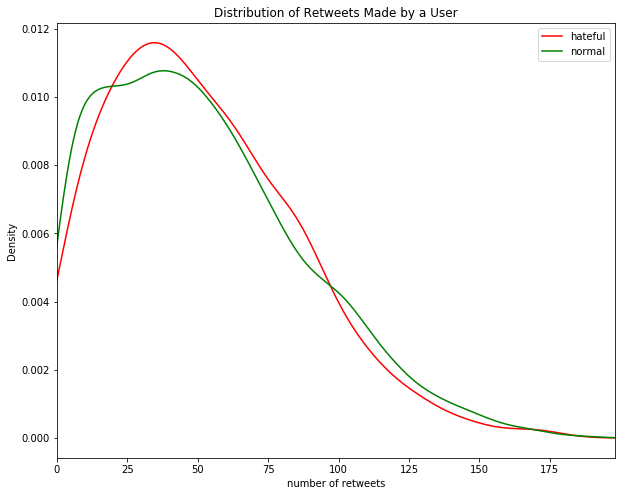

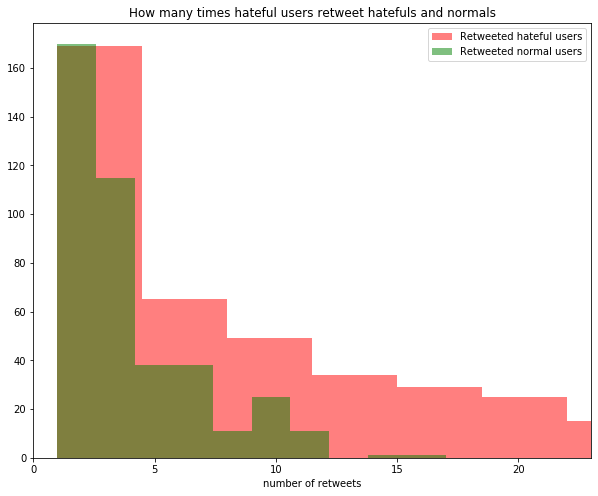

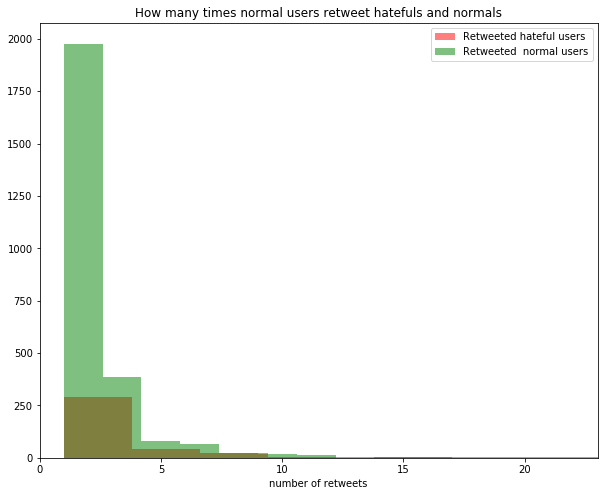

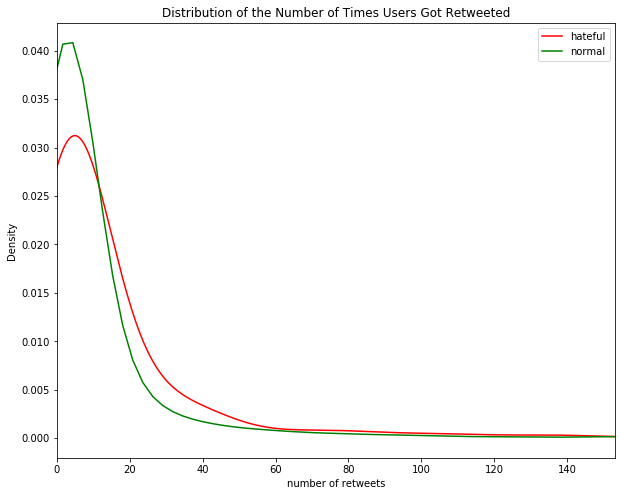

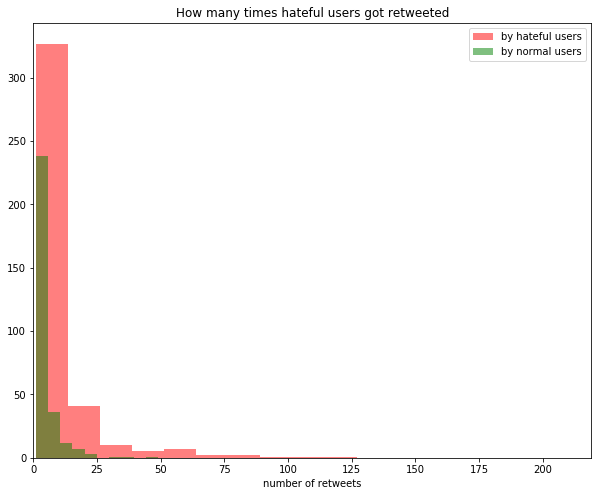

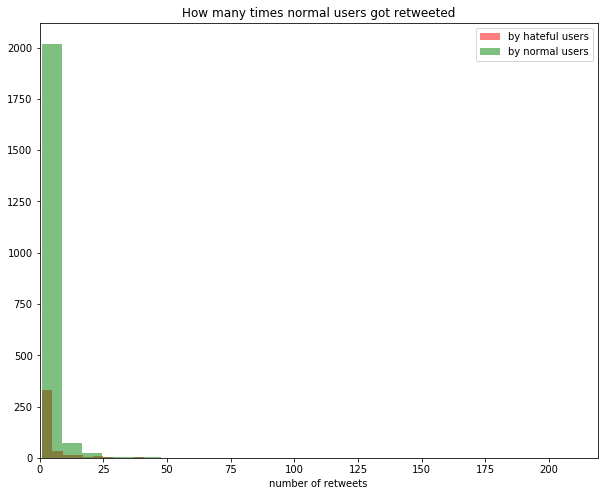

In [70]:
plt.figure(figsize=(10,8))
temp = u2u.groupby(['user_id','hate']).size()
temp[temp.index.get_level_values('hate') == 'hateful'].plot.kde(label='hateful', c='r')
temp[temp.index.get_level_values('hate') == 'normal'].plot.kde(label='normal', c='g')
plt.legend(loc='best')
plt.title('Distribution of Retweets Made by a User')
plt.xlabel('number of retweets')
plt.xlim(left=0, right=temp.max())
plt.show()

plt.figure(figsize=(10,8))
temp = u2u[u2u.hate_rt_user=='hateful'].groupby(['user_id','hate']).size()
plt.hist(temp[temp.index.get_level_values('hate') == 'hateful'].values, alpha=0.5, label='Retweeted hateful users', color='r')
temp = u2u[u2u.hate_rt_user=='normal'].groupby(['user_id','hate']).size()
plt.hist(temp[temp.index.get_level_values('hate') == 'hateful'].values, alpha=0.5, label='Retweeted normal users', color='g')
plt.legend(loc='best')
plt.title('How many times hateful users retweet hatefuls and normals')
plt.xlabel('number of retweets')
plt.xlim(left=0, right=temp.max())
plt.show()

plt.figure(figsize=(10,8))
temp = u2u[u2u.hate_rt_user=='hateful'].groupby(['user_id','hate']).size()
plt.hist(temp[temp.index.get_level_values('hate') == 'normal'].values, alpha=0.5, label='Retweeted hateful users', color='r')
temp = u2u[u2u.hate_rt_user=='normal'].groupby(['user_id','hate']).size()
plt.hist(temp[temp.index.get_level_values('hate') == 'normal'].values, alpha=0.5, label='Retweeted  normal users', color='g')
plt.legend(loc='best')
plt.title('How many times normal users retweet hatefuls and normals')
plt.xlabel('number of retweets')
plt.xlim(left=0, right=temp.max())
plt.show()



plt.figure(figsize=(10,8))
temp = u2u.groupby(['rt_user_id','hate_rt_user']).size()
temp[temp.index.get_level_values('hate_rt_user') == 'hateful'].plot.kde(label='hateful', c='r')
temp[temp.index.get_level_values('hate_rt_user') == 'normal'].plot.kde(label='normal', c='g')
plt.legend(loc='best')
plt.title('Distribution of the Number of Times Users Got Retweeted')
plt.xlabel('number of retweets')
plt.xlim(left=0, right=temp.quantile(.975))
plt.show()

plt.figure(figsize=(10,8))
temp = u2u[u2u.hate=='hateful'].groupby(['rt_user_id','hate_rt_user']).size()
plt.hist(temp[temp.index.get_level_values('hate_rt_user') == 'hateful'].values, alpha=0.5, label='by hateful users', color='r')
temp = u2u[u2u.hate=='normal'].groupby(['rt_user_id','hate_rt_user']).size()
plt.hist(temp[temp.index.get_level_values('hate_rt_user') == 'hateful'].values, alpha=0.5, label='by normal users', color='g')
plt.legend(loc='best')
plt.title('How many times hateful users got retweeted')
plt.xlabel('number of retweets')
plt.xlim(left=0, right=temp.max())
plt.show()

plt.figure(figsize=(10,8))
temp = u2u[u2u.hate=='hateful'].groupby(['rt_user_id','hate_rt_user']).size()
plt.hist(temp[temp.index.get_level_values('hate_rt_user') == 'normal'].values, alpha=0.5, label='by hateful users', color='r')
temp = u2u[u2u.hate=='normal'].groupby(['rt_user_id','hate_rt_user']).size()
plt.hist(temp[temp.index.get_level_values('hate_rt_user') == 'normal'].values, alpha=0.5, label='by normal users', color='g')
plt.legend(loc='best')
plt.title('How many times normal users got retweeted')
plt.xlabel('number of retweets')
plt.xlim(left=0, right=temp.max())
plt.show()

replies

In [87]:
df_tweets = pd.read_csv('../twitter_data/nonpublic/tweets.csv',
#         index_col=["date", "loc"], 
        usecols=["user_id", "tweet_id", "rp_flag", "rp_user", "rp_status"],
        dtype={'user_id':np.int64, 'tweet_id':np.int64, 'rp_flag':np.bool, 'rp_user':str, 'rp_status':str }
)

df_tweets['rp_user'] = pd.to_numeric(df_tweets['rp_user'], downcast='integer', errors='coerce').fillna(-1)
df_tweets['rp_status'] = pd.to_numeric(df_tweets['rp_status'], downcast='integer', errors='coerce').fillna(-1)

In [88]:
rp_tweets = df_tweets[df_tweets.rp_flag == True]

In [91]:
u2u = rp_tweets[['user_id', 'rp_user']].drop_duplicates()
print(f'u2u connections: {u2u.shape[0]}')
u2u = u2u.merge(u2l, how='left', left_on='user_id', right_on='user_id_original', suffixes=('', '_tweeting_user'))
u2u = u2u.merge(u2l, how='left', left_on='rp_user', right_on='user_id_original', suffixes=('', '_rp_user'))

u2u connections: 2257385


In [96]:
(rp_tweets.rp_status<0).shape

(4046662,)

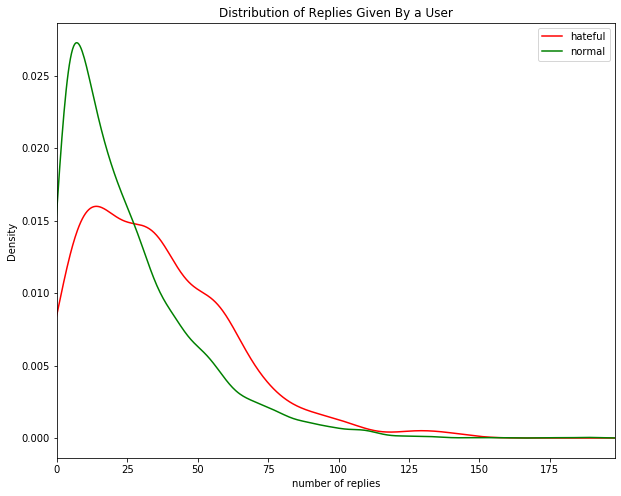

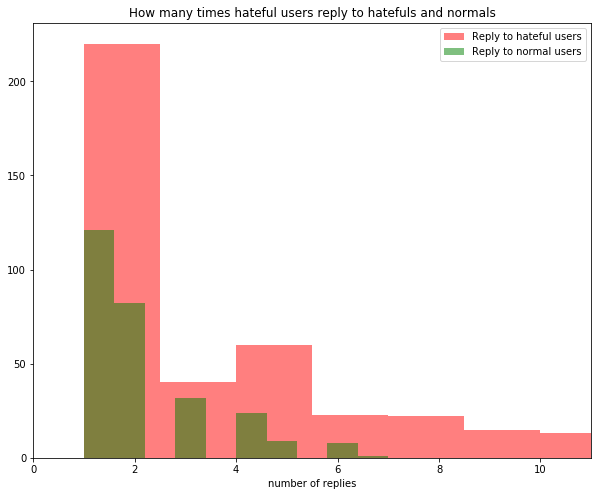

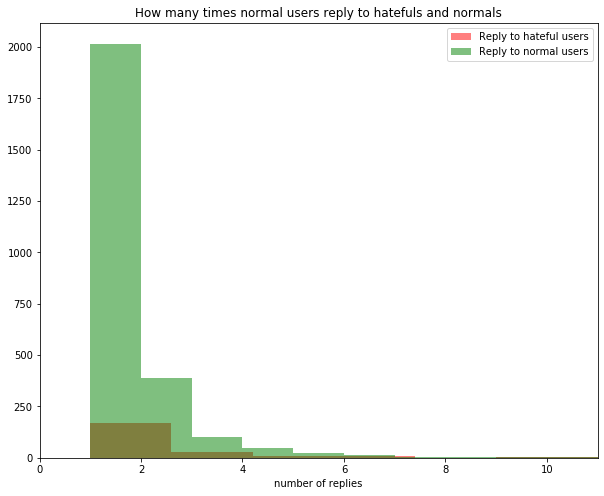

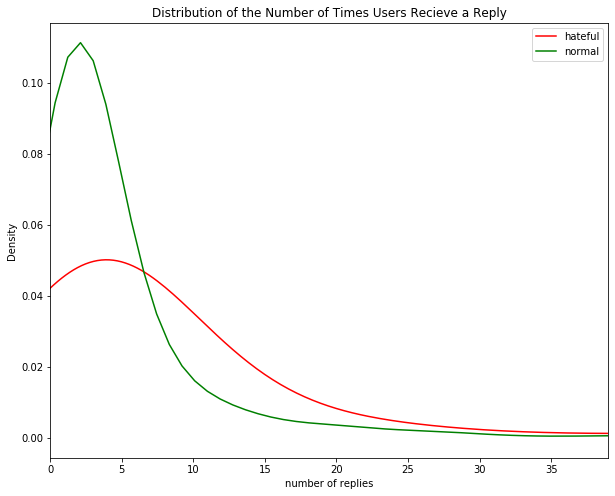

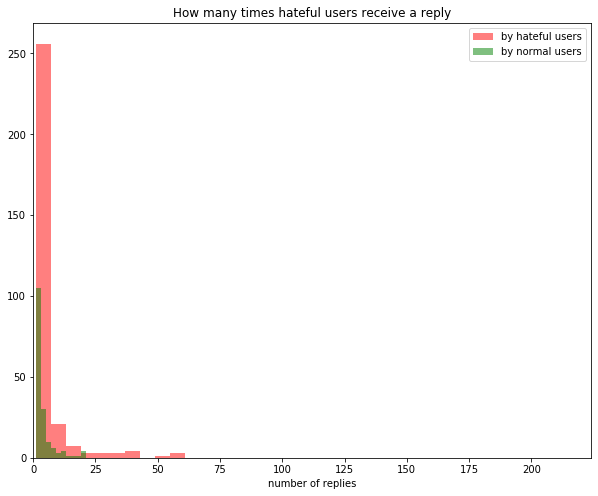

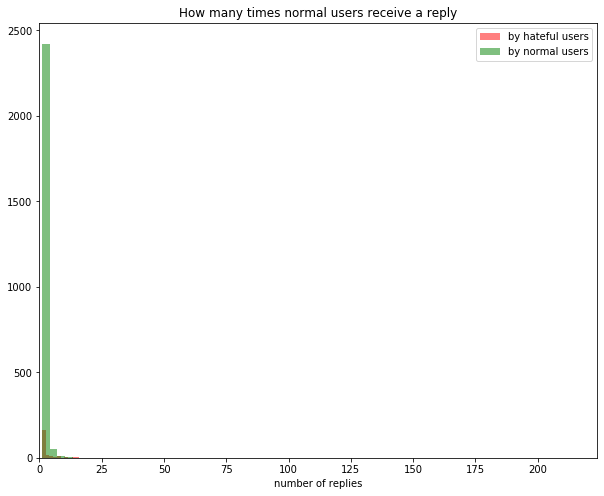

In [74]:
plt.figure(figsize=(10,8))
temp = u2u.groupby(['user_id','hate']).size()
temp[temp.index.get_level_values('hate') == 'hateful'].plot.kde(label='hateful', c='r')
temp[temp.index.get_level_values('hate') == 'normal'].plot.kde(label='normal', c='g')
plt.legend(loc='best')
plt.title('Distribution of Replies Given By a User')
plt.xlabel('number of replies')
plt.xlim(left=0, right=temp.max())
plt.show()

plt.figure(figsize=(10,8))
temp = u2u[u2u.hate_rp_user=='hateful'].groupby(['user_id','hate']).size()
plt.hist(temp[temp.index.get_level_values('hate') == 'hateful'].values, alpha=0.5, label='Reply to hateful users', color='r')
temp = u2u[u2u.hate_rp_user=='normal'].groupby(['user_id','hate']).size()
plt.hist(temp[temp.index.get_level_values('hate') == 'hateful'].values, alpha=0.5, label='Reply to normal users', color='g')
plt.legend(loc='best')
plt.title('How many times hateful users reply to hatefuls and normals')
plt.xlabel('number of replies')
plt.xlim(left=0, right=temp.max())
plt.show()

plt.figure(figsize=(10,8))
temp = u2u[u2u.hate_rp_user=='hateful'].groupby(['user_id','hate']).size()
plt.hist(temp[temp.index.get_level_values('hate') == 'normal'].values, alpha=0.5, label='Reply to hateful users', color='r')
temp = u2u[u2u.hate_rp_user=='normal'].groupby(['user_id','hate']).size()
plt.hist(temp[temp.index.get_level_values('hate') == 'normal'].values, alpha=0.5, label='Reply to normal users', color='g')
plt.legend(loc='best')
plt.title('How many times normal users reply to hatefuls and normals')
plt.xlabel('number of replies')
plt.xlim(left=0, right=temp.max())
plt.show()



plt.figure(figsize=(10,8))
temp = u2u.groupby(['rp_user','hate_rp_user']).size()
temp[temp.index.get_level_values('hate_rp_user') == 'hateful'].plot.kde(label='hateful', c='r')
temp[temp.index.get_level_values('hate_rp_user') == 'normal'].plot.kde(label='normal', c='g')
plt.legend(loc='best')
plt.title('Distribution of the Number of Times Users Recieve a Reply')
plt.xlabel('number of replies')
plt.xlim(left=0, right=temp.quantile(.975))
plt.show()

plt.figure(figsize=(10,8))
temp = u2u[u2u.hate=='hateful'].groupby(['rp_user','hate_rp_user']).size()
plt.hist(temp[temp.index.get_level_values('hate_rp_user') == 'hateful'].values, alpha=0.5, label='by hateful users', color='r')
temp = u2u[u2u.hate=='normal'].groupby(['rp_user','hate_rp_user']).size()
plt.hist(temp[temp.index.get_level_values('hate_rp_user') == 'hateful'].values, alpha=0.5, label='by normal users', color='g')
plt.legend(loc='best')
plt.title('How many times hateful users receive a reply')
plt.xlabel('number of replies')
plt.xlim(left=0, right=temp.max())
plt.show()

plt.figure(figsize=(10,8))
temp = u2u[u2u.hate=='hateful'].groupby(['rp_user','hate_rp_user']).size()
plt.hist(temp[temp.index.get_level_values('hate_rp_user') == 'normal'].values, alpha=0.5, label='by hateful users', color='r')
temp = u2u[u2u.hate=='normal'].groupby(['rp_user','hate_rp_user']).size()
plt.hist(temp[temp.index.get_level_values('hate_rp_user') == 'normal'].values, alpha=0.5, label='by normal users', color='g')
plt.legend(loc='best')
plt.title('How many times normal users receive a reply')
plt.xlabel('number of replies')
plt.xlim(left=0, right=temp.max())
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
temp = u2u[u2u.hate_rt_user=='hateful'].groupby(['user_id','hate']).size()
temp[temp.index.get_level_values('hate') == 'hateful'].plot.kde(label='hateful')
temp[temp.index.get_level_values('hate') == 'normal'].plot.kde(label='normal')
# temp[temp.index.get_level_values('hate') == 'other'].plot.kde(label='unlabeled')
plt.legend(loc='best')
plt.title('Distribution of Retweets from Hateful Users')
plt.xlabel('number of retweets')

In [49]:
# number of edges - quantiles
u2u.groupby(['user_id','hate']).size().groupby(['hate']).quantile([.1,0.25, 0.5, 0.75,.9]).unstack(1)

,0.10,0.25,0.50,0.75,0.90
hate,,,,,
hateful,11.0,25.5,47.0,72.5,96.0
normal,9.0,23.0,47.0,74.0,103.0
other,8.0,21.0,42.0,69.0,97.0


In [ ]:
u2u.groupby(['user_id','hate']).size().groupby(['hate']).quantile([.1,0.25, 0.5, 0.75,.9]).unstack(1)

In [51]:
# number of edges - quantiles
u2u[u2u.hate_rt_user=='hateful'].groupby(['user_id','hate']).size().groupby(['hate']).quantile([.1,0.25, 0.5, 0.75,.9]).unstack(1)

,0.10,0.25,0.50,0.75,0.90
hate,,,,,
hateful,1.0,2.0,6.0,13.0,20.0
normal,1.0,1.0,1.0,3.0,7.0
other,1.0,1.0,1.0,1.0,3.0


In [52]:
u2u[u2u.hate_rt_user=='normal'].groupby(['user_id','hate']).size().groupby(['hate']).quantile([.1,0.25, 0.5, 0.75,.9]).unstack(1)

,0.10,0.25,0.50,0.75,0.90
hate,,,,,
hateful,1.0,2.0,3.0,5.0,8.0
normal,1.0,1.0,1.0,2.0,4.0
other,1.0,1.0,1.0,2.0,3.0


In [55]:
u2u[u2u.hate_rt_user=='other'].groupby(['user_id','hate']).size().groupby(['hate']).quantile([.1,0.25, 0.5, 0.75,.9]).unstack(1)

,0.10,0.25,0.50,0.75,0.90
hate,,,,,
hateful,3.0,7.0,16.0,30.0,50.0
normal,3.0,7.0,17.0,35.0,59.0
other,3.0,6.0,15.0,32.0,55.0


In [57]:
u2u[pd.isna(u2u.hate_rt_user)].groupby(['user_id','hate']).size().groupby(['hate']).quantile([.1,0.25, 0.5, 0.75,.9]).unstack(1)

,0.10,0.25,0.50,0.75,0.90
hate,,,,,
hateful,4.0,9.0,18.0,29.0,42.0
normal,5.0,12.0,24.0,39.0,54.0
other,4.0,10.0,21.0,37.0,53.0


How much are they retweeted

In [59]:
# number of edges - quantiles
u2u.groupby(['rt_user_id','hate_rt_user']).size().groupby(['hate_rt_user']).quantile([.1,0.25, 0.5, 0.75,.9]).unstack(1)

,0.10,0.25,0.50,0.75,0.90
hate_rt_user,,,,,
hateful,1.0,2.0,5.0,14.5,38.0
normal,1.0,1.0,3.0,7.0,23.0
other,1.0,2.0,5.0,17.0,50.0


In [60]:
# number of edges - quantiles
u2u[u2u.hate=='normal'].groupby(['rt_user_id','hate_rt_user']).size().groupby(['hate_rt_user']).quantile([.1,0.25, 0.5, 0.75,.9]).unstack(1)

,0.10,0.25,0.50,0.75,0.90
hate_rt_user,,,,,
hateful,1.0,1.0,2.0,4.0,9.0
normal,1.0,1.0,1.0,2.0,5.0
other,1.0,1.0,2.0,3.0,7.0


In [61]:
# number of edges - quantiles
u2u[u2u.hate=='hateful'].groupby(['rt_user_id','hate_rt_user']).size().groupby(['hate_rt_user']).quantile([.1,0.25, 0.5, 0.75,.9]).unstack(1)

,0.10,0.25,0.50,0.75,0.90
hate_rt_user,,,,,
hateful,1.0,1.0,3.0,8.0,22.0
normal,1.0,1.0,1.0,3.0,9.9
other,1.0,1.0,1.0,2.0,4.0


In [62]:
# number of edges - quantiles
u2u[u2u.hate=='other'].groupby(['rt_user_id','hate_rt_user']).size().groupby(['hate_rt_user']).quantile([.1,0.25, 0.5, 0.75,.9]).unstack(1)

,0.10,0.25,0.50,0.75,0.90
hate_rt_user,,,,,
hateful,1.0,1.0,3.0,8.0,22.3
normal,1.0,1.0,2.0,6.0,20.0
other,1.0,2.0,5.0,17.0,48.0


In [ ]:
# number of edges - quantiles
u2u.groupby(['rt_user_id','hate_rt_user']).size().groupby(['hate_rt_user']).quantile([.1,0.25, 0.5, 0.75,.9]).unstack(1)

In [58]:
u2u.head()

,user_id,rt_user_id,hate,hate_rt_user
0,850859913244852224,258324826,hateful,normal
1,850859913244852224,1289954977,hateful,NaN
2,850859913244852224,850408392925499392,hateful,hateful
3,850859913244852224,14677919,hateful,other
4,850859913244852224,4573876514,hateful,NaN


In [26]:
df_tweets[df_tweets.rt_flag==1].head()

,user_id,tweet_id,rt_flag,rt_status_id,rt_user_id
2,850859913244852224,919367819694927872,True,9.144992e+17,2.583248e+08
3,850859913244852224,919366633512226816,True,9.189423e+17,1.289955e+09
4,850859913244852224,919365144697860096,True,9.193076e+17,8.504084e+17
5,850859913244852224,919361129226399745,True,9.190351e+17,1.467792e+07
6,850859913244852224,919357843345674240,True,9.193077e+17,4.573877e+09


In [9]:
list(df.columns)

['user_id',
 'hate',
 'hate_neigh',
 'normal_neigh',
 'statuses_count',
 'followers_count',
 'followees_count',
 'favorites_count',
 'listed_count',
 'betweenness',
 'eigenvector',
 'in_degree',
 'out_degree',
 'negotiate_empath',
 'vehicle_empath',
 'science_empath',
 'timidity_empath',
 'gain_empath',
 'swearing_terms_empath',
 'office_empath',
 'tourism_empath',
 'computer_empath',
 'violence_empath',
 'horror_empath',
 'dispute_empath',
 'sadness_empath',
 'internet_empath',
 'college_empath',
 'attractive_empath',
 'plant_empath',
 'technology_empath',
 'reading_empath',
 'deception_empath',
 'ancient_empath',
 'ship_empath',
 'messaging_empath',
 'surprise_empath',
 'occupation_empath',
 'hearing_empath',
 'furniture_empath',
 'restaurant_empath',
 'domestic_work_empath',
 'art_empath',
 'pet_empath',
 'air_travel_empath',
 'dance_empath',
 'healing_empath',
 'smell_empath',
 'sympathy_empath',
 'anger_empath',
 'neglect_empath',
 'farming_empath',
 'clothing_empath',
 'wedding_e

In [ ]:
df.